In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
orders_sdf = spark.read.csv('/FileStore/tables/orders.csv', header=True, inferSchema=True)
trains_sdf = spark.read.csv('/FileStore/tables/order_products_train.csv', header=True, inferSchema=True)
products_sdf = spark.read.csv('/FileStore/tables/products.csv', header=True, inferSchema=True)
aisles_sdf = spark.read.csv('/FileStore/tables/aisles.csv', header=True, inferSchema=True)
depts_sdf = spark.read.csv('/FileStore/tables/departments.csv', header=True, inferSchema=True)

300MB 이상의 파일을 Databricks cloud storage에 upload 되지 않으므로 order_products_prior.zip 파일을 압축된 채 그대로 로드하고, 이를 pandas의 read_csv()의 option인 compressed를 이용하여 pandas DataFrame으로 로드한 뒤 다시 spark DataFrame으로 변환

In [0]:
%fs 
cp /FileStore/tables/order_products_prior.zip file:/home/order_products_prior.zip 

res0: Boolean = true

In [0]:
%sh
ls -lia /home

total 162196
6838442 drwxr-xr-x 1 root   root        4096 Nov 12 13:51 .
 393219 drwxr-xr-x 1 root   root        4096 Nov 12 13:34 ..
 395227 -rw-r--r-- 1 root   root     1287340 Nov 12 13:51 .order_products_prior.zip.crc
 395225 -rw-r--r-- 1 root   root   164778226 Nov 12 13:51 order_products_prior.zip
6838443 drwxr-xr-x 1 ubuntu ubuntu      4096 Nov 12 13:34 ubuntu


In [0]:
import pandas as pd

priors_pdf = pd.read_csv('/home/order_products_prior.zip', compression='zip', header=0, sep=',', quotechar='"')
priors_sdf = spark.createDataFrame(priors_pdf)

In [0]:
del priors_pdf # 메모리 절약을 위해 pandas dataframe삭제 

In [0]:
sdf_dict = {"orders":orders_sdf, "order_product_train":trains_sdf, "order_product_prior":priors_sdf, 
            "product":products_sdf, "aisles":aisles_sdf, "departments":depts_sdf
           }
for sdf_name, sdf in sdf_dict.items():
    print("########## ", sdf_name, "schema ###########")
    print(sdf.printSchema())

##########  orders schema ###########
root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)

None
##########  order_product_train schema ###########
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)

None
##########  order_product_prior schema ###########
root
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- add_to_cart_order: long (nullable = true)
 |-- reordered: long (nullable = true)

None
##########  product schema ###########
root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |--

In [0]:
# 로드한 DataFrame을 임시 table/view로 생성. 
orders_sdf.createOrReplaceTempView("orders")
priors_sdf.createOrReplaceTempView("priors")
trains_sdf.createOrReplaceTempView("trains")
products_sdf.createOrReplaceTempView("products")
aisles_sdf.createOrReplaceTempView("aisles")
depts_sdf.createOrReplaceTempView("depts")

In [0]:
# temporary table/view로 등록되어 있는지 확인. 
spark.catalog.listTables()

Out[10]: [Table(name='aisles', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='depts', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='orders', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='priors', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='products', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='trains', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

#### orders 테이블 
개별 user_id로 prior는 여러개의 order_id를 가지나 train과 test는  단 1개의 order_id를 가짐. 
즉 eval_set가 train인 경우는 user_id와 order_id가 1:1의 관계임
* order_id: 주문번호
* user_id: 고객번호
* eval_set : order 데이터의 prior/train/test 구분
* order_number: 개별 사용자별 주문 순번
* order_dow: 주문 요일을 숫자로 나타냄(토~금)
* order_hour_of_day: 주문 시간을 숫자로 나타냄(0~23)
* days_since_prior_order: 이전 주문 이후 현 주문까지 걸린 일자. 첫 주문은 Null

#### order_product_prior
개별 주문의 상품 정보. 과거 주문의 상품 정보 가짐. 
* order_id: 주문번호
* product_id: 상품번호
* add_to_cart_order: 개별 주문에서 상품을 cart에 담은 순서
* reordered: 개별 사용자 별 해당 상품에 대한 재 주문 여부. 1은 재 주문, 0은 첫 주문. 학습 모델의 target 속성 임. 

#### order_product_train
개별 주문의 상품 정보. 개별 사용자당 한개의 주문 정보. 
* order_id: 주문번호
* product_id: 상품번호
* add_to_cart_order: 개별 주문에서 상품을 cart에 담은 순서
* reordered: 개별 사용자 별 해당 상품에 대한 재 주문 여부. 1은 재 주문, 0은 첫 주문. 학습 모델의 target 속성 임.

In [0]:
%sql
select * from orders limit 10

order_id user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 2539329 1 prior 1 2 8 null 2398795 1 prior 2 3 7 15.0 473747 1 prior 3 3 12 21.0 2254736 1 prior 4 4 7 29.0 431534 1 prior 5 4 15 28.0 3367565 1 prior 6 2 7 19.0 550135 1 prior 7 1 9 20.0 3108588 1 prior 8 1 14 14.0 2295261 1 prior 9 1 16 0.0 2550362 1 prior 10 4 8 30.0

In [0]:
%sql
select * from orders where user_id = 1

order_id user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 2539329 1 prior 1 2 8 null 2398795 1 prior 2 3 7 15.0 473747 1 prior 3 3 12 21.0 2254736 1 prior 4 4 7 29.0 431534 1 prior 5 4 15 28.0 3367565 1 prior 6 2 7 19.0 550135 1 prior 7 1 9 20.0 3108588 1 prior 8 1 14 14.0 2295261 1 prior 9 1 16 0.0 2550362 1 prior 10 4 8 30.0 1187899 1 train 11 4 8 14.0

In [0]:
%sql
select * from priors limit 10

order_id product_id add_to_cart_order reordered 2 33120 1 1 2 28985 2 1 2 9327 3 0 2 45918 4 1 2 30035 5 0 2 17794 6 1 2 40141 7 1 2 1819 8 1 2 43668 9 0 3 33754 1 1

In [0]:
%sql
select * from priors where order_id = 2398795

order_id product_id add_to_cart_order reordered 2398795 196 1 1 2398795 10258 2 0 2398795 12427 3 1 2398795 13176 4 0 2398795 26088 5 1 2398795 13032 6 0

In [0]:
%sql
select * from trains limit 10

order_id product_id add_to_cart_order reordered 1 49302 1 1 1 11109 2 1 1 10246 3 0 1 49683 4 0 1 43633 5 1 1 13176 6 0 1 47209 7 0 1 22035 8 1 36 39612 1 0 36 19660 2 1

In [0]:
%sql
select * from orders where user_id = (select user_id from orders where order_id=1) 

order_id user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 1427983 112108 prior 1 1 14 null 2541372 112108 prior 2 1 10 7.0 186706 112108 prior 3 2 21 15.0 1 112108 train 4 4 10 9.0

In [0]:
%sql
select * from trains where order_id = 1

order_id product_id add_to_cart_order reordered 1 49302 1 1 1 11109 2 1 1 10246 3 0 1 49683 4 0 1 43633 5 1 1 13176 6 0 1 47209 7 0 1 22035 8 1

- 개별 user가 주문한 여러건의 주문 데이터를 가지고 있음. 첫 주문의 경우 days_since_prior_order가 null임. 
- eval_set은 해당 주문의 주문 상품 데이터가 priors에 있는지, trains/test에 있는지를 나타냄
- 개별 user의 여러건의 주문 데이터 중, 가장 최근 1건의 order만 trains/test에 속함. 나머지 건은 모두 priors에 속함.
- 개별 주문의 여러건의 과거 상품 주문 데이터를 가지고 있음. 개별 user가 주문한 여러건의 주문 정보를 가짐. reordered가 해당 상품에 대한 재주문 여부이며 1이 재주문, 0이 첫주문 임.
- user_id 1의 order_id 2398795의 과거 상품 주문 정보 확인. order_id 2539329는 첫주문이므로 priors의 reordered는 모두 0
- 개별 주문의 여러건의 상품 주문 데이터를 가지고 있음. 개별 user가 주문한 1건의 주문정보를 가짐.
- order_id 1은 user_id 112108 을 가지고 있으며 user_id 112108은 여러건의 주문을 가짐.

In [0]:
%sql
-- 상품에 대한 정보를 가짐. aisle_id는 상품 중분류, department_id는 상품 대분류. 마트의 복도 선반별(aisles), 특정 층또는 구역(departments)
select a.*, b.aisle, c.department 
from products a, aisles b, depts c
where a.aisle_id = b.aisle_id and a.department_id = c.department_id

product_id product_name aisle_id department_id aisle department 1 Chocolate Sandwich Cookies 61 19 cookies cakes snacks 2 All-Seasons Salt 104 13 spices seasonings pantry 3 Robust Golden Unsweetened Oolong Tea 94 7 tea beverages 4 Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce 38 1 frozen meals frozen 5 Green Chile Anytime Sauce 5 13 marinades meat preparation pantry 6 Dry Nose Oil 11 11 cold flu allergy personal care 7 Pure Coconut Water With Orange 98 7 juice nectars beverages 8 Cut Russet Potatoes Steam N' Mash 116 1 frozen produce frozen 9 Light Strawberry Blueberry Yogurt 120 16 yogurt dairy eggs 10 Sparkling Orange Juice & Prickly Pear Beverage 115 7 water seltzer sparkling water beverages 11 Peach Mango Juice 31 7 refrigerated beverages 12 Chocolate Fudge Layer Cake 119 1 frozen dessert frozen 13 Saline Nasal Mist 11 11 cold flu allergy personal care 14 Fresh Scent Dishwasher Cleaner 74 17 dish detergents household 15 Overnight Diapers Size 6 56 18 diapers wipes babies 16 Mint Chocolate Flavored Syrup 103 19 ice cream toppings snacks 17 Rendered Duck Fat 35 12 poultry counter meat seafood 18 Pizza for One Suprema Frozen Pizza 79 1 frozen pizza frozen 19 Gluten Free Quinoa Three Cheese & Mushroom Blend 63 9 grains rice dried goods dry goods pasta 20 Pomegranate Cranberry & Aloe Vera Enrich Drink 98 7 juice nectars beverages 21 Small & Medium Dental Dog Treats 40 8 dog food care pets 22 Fresh Breath Oral Rinse Mild Mint 20 11 oral hygiene personal care 23 Organic Turkey Burgers 49 12 packaged poultry meat seafood 24 Tri-Vi-Sol® Vitamins A-C-and D Supplement Drops for Infants 47 11 vitamins supplements personal care 25 Salted Caramel Lean Protein & Fiber Bar 3 19 energy granola bars snacks 26 Fancy Feast Trout Feast Flaked Wet Cat Food 41 8 cat food care pets 27 Complete Spring Water Foaming Antibacterial Hand Wash 127 11 body lotions soap personal care 28 Wheat Chex Cereal 121 14 cereal breakfast 29 Fresh Cut Golden Sweet No Salt Added Whole Kernel Corn 81 15 canned jarred vegetables canned goods 30 Three Cheese Ziti, Marinara with Meatballs 38 1 frozen meals frozen 31 White Pearl Onions 123 4 packaged vegetables fruits produce 32 Nacho Cheese White Bean Chips 107 19 chips pretzels snacks 33 Organic Spaghetti Style Pasta 131 9 dry pasta dry goods pasta 34 Peanut Butter Cereal 121 14 cereal breakfast 35 Italian Herb Porcini Mushrooms Chicken Sausage 106 12 hot dogs bacon sausage meat seafood 36 Traditional Lasagna with Meat Sauce Savory Italian Recipes 38 1 frozen meals frozen 37 Noodle Soup Mix With Chicken Broth 69 15 soup broth bouillon canned goods 38 Ultra Antibacterial Dish Liquid 100 21 missing missing 39 Daily Tangerine Citrus Flavored Beverage 64 7 energy sports drinks beverages 40 Beef Hot Links Beef Smoked Sausage With Chile Peppers 106 12 hot dogs bacon sausage meat seafood 41 Organic Sourdough Einkorn Crackers Rosemary 78 19 crackers snacks 42 Biotin 1000 mcg 47 11 vitamins supplements personal care 43 Organic Clementines 123 4 packaged vegetables fruits produce 44 Sparkling Raspberry Seltzer 115 7 water seltzer sparkling water beverages 45 European Cucumber 83 4 fresh vegetables produce 46 Raisin Cinnamon Bagels 5 count 58 1 frozen breads doughs frozen 47 Onion Flavor Organic Roasted Seaweed Snack 66 6 asian foods international 48 School Glue, Washable, No Run 87 17 more household household 49 Vegetarian Grain Meat Sausages Italian - 4 CT 14 20 tofu meat alternatives deli 50 Pumpkin Muffin Mix 105 13 doughs gelatins bake mixes pantry 51 Sa Extra Hold Mousse Hair Styling 22 11 hair care personal care 52 Mirabelle Brut Rose 134 5 specialty wines champagnes alcohol 53 Whole Leaf Pure Aloe With Lemon Juice 98 7 juice nectars beverages 54 24/7 Performance Cat Litter 41 8 cat food care pets 55 Lasting Color Shampoo 22 11 hair care personal care 56 Healthy Pop Butter Popcorn 23 19 popcorn jerky snacks 57 Flat Toothpicks 111 17 plates bowls cups flatware household 58 Whole Wheat Tortillas 128 3 tor

In [0]:
%sql
select
  a.*,
  b.aisle,
  c.department
from
  products a,
  aisles b,
  depts c
where
  a.aisle_id = b.aisle_id
  and a.department_id = c.department_id

product_id product_name aisle_id department_id aisle department 1 Chocolate Sandwich Cookies 61 19 cookies cakes snacks 2 All-Seasons Salt 104 13 spices seasonings pantry 3 Robust Golden Unsweetened Oolong Tea 94 7 tea beverages 4 Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce 38 1 frozen meals frozen 5 Green Chile Anytime Sauce 5 13 marinades meat preparation pantry 6 Dry Nose Oil 11 11 cold flu allergy personal care 7 Pure Coconut Water With Orange 98 7 juice nectars beverages 8 Cut Russet Potatoes Steam N' Mash 116 1 frozen produce frozen 9 Light Strawberry Blueberry Yogurt 120 16 yogurt dairy eggs 10 Sparkling Orange Juice & Prickly Pear Beverage 115 7 water seltzer sparkling water beverages 11 Peach Mango Juice 31 7 refrigerated beverages 12 Chocolate Fudge Layer Cake 119 1 frozen dessert frozen 13 Saline Nasal Mist 11 11 cold flu allergy personal care 14 Fresh Scent Dishwasher Cleaner 74 17 dish detergents household 15 Overnight Diapers Size 6 56 18 diapers wipes babies 16 Mint Chocolate Flavored Syrup 103 19 ice cream toppings snacks 17 Rendered Duck Fat 35 12 poultry counter meat seafood 18 Pizza for One Suprema Frozen Pizza 79 1 frozen pizza frozen 19 Gluten Free Quinoa Three Cheese & Mushroom Blend 63 9 grains rice dried goods dry goods pasta 20 Pomegranate Cranberry & Aloe Vera Enrich Drink 98 7 juice nectars beverages 21 Small & Medium Dental Dog Treats 40 8 dog food care pets 22 Fresh Breath Oral Rinse Mild Mint 20 11 oral hygiene personal care 23 Organic Turkey Burgers 49 12 packaged poultry meat seafood 24 Tri-Vi-Sol® Vitamins A-C-and D Supplement Drops for Infants 47 11 vitamins supplements personal care 25 Salted Caramel Lean Protein & Fiber Bar 3 19 energy granola bars snacks 26 Fancy Feast Trout Feast Flaked Wet Cat Food 41 8 cat food care pets 27 Complete Spring Water Foaming Antibacterial Hand Wash 127 11 body lotions soap personal care 28 Wheat Chex Cereal 121 14 cereal breakfast 29 Fresh Cut Golden Sweet No Salt Added Whole Kernel Corn 81 15 canned jarred vegetables canned goods 30 Three Cheese Ziti, Marinara with Meatballs 38 1 frozen meals frozen 31 White Pearl Onions 123 4 packaged vegetables fruits produce 32 Nacho Cheese White Bean Chips 107 19 chips pretzels snacks 33 Organic Spaghetti Style Pasta 131 9 dry pasta dry goods pasta 34 Peanut Butter Cereal 121 14 cereal breakfast 35 Italian Herb Porcini Mushrooms Chicken Sausage 106 12 hot dogs bacon sausage meat seafood 36 Traditional Lasagna with Meat Sauce Savory Italian Recipes 38 1 frozen meals frozen 37 Noodle Soup Mix With Chicken Broth 69 15 soup broth bouillon canned goods 38 Ultra Antibacterial Dish Liquid 100 21 missing missing 39 Daily Tangerine Citrus Flavored Beverage 64 7 energy sports drinks beverages 40 Beef Hot Links Beef Smoked Sausage With Chile Peppers 106 12 hot dogs bacon sausage meat seafood 41 Organic Sourdough Einkorn Crackers Rosemary 78 19 crackers snacks 42 Biotin 1000 mcg 47 11 vitamins supplements personal care 43 Organic Clementines 123 4 packaged vegetables fruits produce 44 Sparkling Raspberry Seltzer 115 7 water seltzer sparkling water beverages 45 European Cucumber 83 4 fresh vegetables produce 46 Raisin Cinnamon Bagels 5 count 58 1 frozen breads doughs frozen 47 Onion Flavor Organic Roasted Seaweed Snack 66 6 asian foods international 48 School Glue, Washable, No Run 87 17 more household household 49 Vegetarian Grain Meat Sausages Italian - 4 CT 14 20 tofu meat alternatives deli 50 Pumpkin Muffin Mix 105 13 doughs gelatins bake mixes pantry 51 Sa Extra Hold Mousse Hair Styling 22 11 hair care personal care 52 Mirabelle Brut Rose 134 5 specialty wines champagnes alcohol 53 Whole Leaf Pure Aloe With Lemon Juice 98 7 juice nectars beverages 54 24/7 Performance Cat Litter 41 8 cat food care pets 55 Lasting Color Shampoo 22 11 hair care personal care 56 Healthy Pop Butter Popcorn 23 19 popcorn jerky snacks 57 Flat Toothpicks 111 17 plates bowls cups flatware household 58 Whole Wheat Tortillas 128 3 tor

In [0]:
%sql
-- 주요 테이블의 건수 확인
SELECT 'priors count' as table_name_count, COUNT(*) cnt FROM priors
union all
select 'trains count', count(*) cnt from trains
union all
SELECT 'orders count', COUNT(*) cnt FROM orders

table_name_count cnt priors count 32434489 trains count 1384617 orders count 3421083

In [0]:
%sql
-- eval_set별 주문 건수 확인
select eval_set, count(*) from orders group by eval_set

eval_set count(1) train 131209 prior 3214874 test 75000

In [0]:
%sql
-- train은 1 user에 1 order이므로 distinct id count가 동일. 
-- prior는 train과 test에 해당하는 user를 가지고 있음. 
-- test도 1 user에 1 order임. 
select eval_set, count(distinct user_id) from orders group by eval_set

eval_set count(DISTINCT user_id) train 131209 prior 206209 test 75000

In [0]:
%sql

select user_id, count(*) cnt from orders group by user_id

user_id cnt 148 8 463 8 471 7 496 83 833 12 1088 16 1238 30 1342 7 1580 10 1591 4 1645 9 1829 7 1959 5 2122 11 2142 14 2366 31 2659 18 2866 38 3175 10 3749 27 3794 87 3918 13 3997 4 4101 6 4519 5 4818 17 4900 18 4935 7 5156 31 5300 8 5518 12 5803 4 6336 19 6357 6 6397 4 6466 8 6620 21 6654 10 6658 12 7240 9 7253 6 7340 10 7554 17 7754 19 7833 29 7880 9 7982 19 7993 11 8086 100 8389 9 8592 5 8638 7 9376 37 9427 6 9465 29 9852 46 9900 7 10206 6 10362 10 10623 10 10817 29 11033 11 11141 6 11317 5 11458 6 11748 5 11858 6 12027 13 12046 54 12799 4 12940 39 13285 18 13289 26 13623 85 13832 11 13840 7 14450 14 14570 7 14832 4 15447 86 15619 6 15727 24 15790 24 15846 44 15957 38 16339 4 16386 33 16503 6 16574 12 16861 4 17389 14 17420 60 17679 82 17753 5 18024 5 18051 4 18498 6 18654 16 18800 10 18866 39 18911 15 18944 5 18979 8 19079 20 19204 23 19530 18 19553 6 19984 15 20135 7 20382 7 20497 4 20683 7 20735 14 20924 65 21220 22 21700 19 22097 77 22223 17 22346 51 22373 61 22521 16 23015 14 23271 12 23336 4 23364 11 23571 8 24171 7 24347 17 24354 5 24663 22 25462 58 25517 45 25591 29 26087 4 26425 4 26583 16 26623 13 26706 12 26708 60 26755 15 27484 23 243 28 392 7 540 6 623 12 737 16 858 31 897 5 1025 8 1084 34 1127 7 1395 4 1460 4 1483 26 1507 4 1522 5 1721 46 1896 4 1990 42 2235 16 2387 100 2563 14 2580 7 2811 4 2999 19 3179 8 3226 36 3475 93 3698 5 4158 9 4161 4 4190 13 4219 7 4929 13 5614 40 6393 15 6623 34 6773 20 7168 26 7417 11 8105 39 8803 58 8928 6 8932 12 9182 23 9564 4 9879 5 10081 8 10121 6 10230 18 10462 5 10703 21 10914 12 11280 4 11316 16 11500 13 11710 10 12006 6 12367 8 12471 4 12611 12 12626 24 12715 24 13261 16 13622 9 14075 20 14148 8 14423 18 14465 5 14514 9 14536 11 14876 20 15003 31 15004 15 15100 44 15254 4 15538 15 15967 6 16500 34 16916 5 17172 5 17607 15 17688 34 18161 24 18201 25 18218 5 18282 9 18467 7 18479 15 18595 11 18902 22 18956 7 19200 12 19206 11 19325 5 19351 6 19499 32 19614 16 19669 32 19758 48 19873 12 19878 19 19886 8 19962 37 20268 16 20396 38 20596 15 20928 21 21116 6 21558 6 21598 27 21715 13 21859 24 22004 6 22021 18 22188 6 22412 33 22555 49 22970 26 22990 6 23136 5 23455 11 23523 7 23607 9 23706 19 23709 7 23727 11 24355 10 24728 40 24873 50 24985 4 25227 41 25283 25 25895 4 26200 12 26544 9 26699 7 26767 19 26787 4 26801 36 26936 16 27118 4 27129 8 27261 8 31 21 516 94 1139 30 1143 4 1270 13 1303 7 1322 5 1339 8 1352 30 1618 5 1650 17 1699 54 1903 6 2393 4 2572 7 2711 6 2776 20 2821 32 2996 7 3000 19 3213 39 3352 6 3488 8 3704 20 3761 4 4391 10 4489 5 5071 21 5117 10 5173 4 5287 74 5345 17 5984 24 6266 4 6482 25 6559 10 6622 9 6825 7 7281 6 7387 6 7850 12 7879 15 8222 4 8257 46 8407 10 8924 47 9162 18 9383 9 9454 4 9517 18 9558 11 10708 22 10798 18 10862 6 11025 13 11393 4 11639 10 11800 32 11936 12 12139 7 12393 4 12998 29 13009 17 13060 5 13207 47 13483 15 13601 4 13648 12 13875 9 13910 21 14289 22 14324 7 14377 17 14420 8 14714 13 14837 6 14997 5 15162 4 15173 11 15207 9 15296 15 15655 12 15738 26 16283 25 16534 15 16680 100 16791 8 16924 34 17008 10 17028 5 17044 19 17077 4 17708 4 17751 13 17754 13 17775 28 17783 59 17809 4 17837 5 18221 5 18382 55 18502 4 18503 6 19023 5 19131 23 19413 34 19526 7 19619 22 19683 4 19868 15 20020 42 20029 24 20052 26 20120 7 20134 6 20247 6 20398 51 20467 5 20506 14 21058 15 21121 4 21633 51 22609 6 22684 11 22951 7 23144 20 23868 18 24078 34 24504 5 24630 12 24719 52 24747 6 24855 13 25106 14 25150 6 25203 6 25638 66 25686 4 26111 21 26128 21 26178 6 26619 9 26646 14 27214 7 27266 5 27471 4 85 8 137 7 251 11 451 33 580 22 808 4 1265 6 1884 22 1975 5 2025 5 2231 100 2259 14 2443 21 2488 29 2525 8 2721 9 2748 8 2923 23 3089 4 3098 30 3220 25 3490 72 3796 13 3876 10 3986 4 4042 7 4078 13 4186 13 4239 7 4364 12 4684 7 4937 8 5074 10 5155 7 5223 11 5308 33 5482 10 6361 7 6597 10 6598 5 7066 4 7098 17 7120 100 7530 17 7644 6 7910 40 8109 10 8650 34 8743 20 8779 100 8911 15 9071 6 9169 10 9946 7 10468 8 10745 5 10768 11 11146 8 11630 9 11713 15 12292 5 

In [0]:
%sql
-- orders의 user_id 별로 대략적인 분포도를 확인
select max(cnt), min(cnt), avg(cnt), count(*) 
from (
  select user_id, count(*) as cnt from orders group by user_id
)

max(cnt) min(cnt) avg(cnt) count(1) 100 4 16.590367054784224 206209

In [0]:
%sql
-- user_id 건수가 많은 순으로 1000개만 출력
select user_id, count(*) cnt from orders group by user_id order by 2 desc limit 1000

user_id cnt 202554 100 183036 100 191277 100 26693 100 179090 100 174854 100 173431 100 310 100 11588 100 8703 100 181416 100 182364 100 164906 100 161869 100 171512 100 1549 100 25414 100 25132 100 5912 100 17086 100 24766 100 14923 100 16290 100 176885 100 162992 100 22395 100 55935 100 182290 100 178113 100 164055 100 166725 100 22337 100 12430 100 3742 100 5101 100 9036 100 15124 100 27208 100 19604 100 9911 100 3514 100 6494 100 14489 100 23744 100 1666 100 9682 100 16357 100 169639 100 161873 100 36481 100 174328 100 1310 100 98628 100 27036 100 24531 100 16364 100 76905 100 169068 100 172806 100 185524 100 168637 100 180793 100 4558 100 17997 100 4284 100 20451 100 26489 100 24562 100 1024 100 4764 100 5732 100 12886 100 9910 100 25876 100 1958 100 690 100 1563 100 13335 100 16689 100 18275 100 5199 100 27430 100 7658 100 21421 100 1428 100 16600 100 25416 100 3960 100 313 100 4711 100 9667 100 964 100 5296 100 19326 100 16298 100 174084 100 178736 100 183139 100 51127 100 39046 100 47302 100 165294 100 166786 100 14414 100 1420 100 89989 100 104339 100 84058 100 44431 100 5329 100 105269 100 100916 100 59819 100 49159 100 29623 100 34000 100 7278 100 186935 100 165813 100 4356 100 186835 100 12641 100 169071 100 172294 100 174521 100 49878 100 32099 100 39993 100 40817 100 47309 100 42711 100 47644 100 41509 100 31606 100 36376 100 54259 100 35048 100 32667 100 45795 100 48890 100 53837 100 38016 100 44182 100 31093 100 38720 100 34340 100 30077 100 42307 100 33104 100 33645 100 50087 100 43352 100 44363 100 40278 100 47809 100 50442 100 31087 100 34628 100 41002 100 31310 100 36916 100 43236 100 43265 100 31617 100 36740 100 39901 100 36149 100 44599 100 50643 100 45361 100 44486 100 35662 100 47855 100 49186 100 28238 100 53452 100 51072 100 51309 100 33218 100 33513 100 36666 100 39328 100 34065 100 28476 100 50024 100 35190 100 39308 100 49406 100 48527 100 41356 100 12772 100 1868 100 28775 100 174046 100 168162 100 53976 100 184906 100 24609 100 4199 100 30650 100 47666 100 40253 100 42520 100 16680 100 180851 100 166908 100 169638 100 4693 100 17742 100 16265 100 89048 100 98085 100 104576 100 93581 100 100142 100 105338 100 91972 100 89799 100 27608 100 19300 100 25422 100 100325 100 88491 100 4490 100 81835 100 71919 100 72726 100 32971 100 45657 100 44834 100 49420 100 6268 100 33731 100 41996 100 3377 100 25005 100 186520 100 83011 100 106724 100 23170 100 6978 100 26988 100 171807 100 90555 100 2231 100 45938 100 181936 100 24908 100 10934 100 172172 100 56033 100 66588 100 69919 100 56886 100 59535 100 64512 100 76784 100 54594 100 75517 100 60932 100 57621 100 62890 100 73765 100 62443 100 74315 100 80828 100 63073 100 65141 100 59365 100 65176 100 72759 100 55806 100 69359 100 61777 100 68891 100 67559 100 71782 100 76729 100 67643 100 71929 100 79279 100 78267 100 59979 100 62772 100 71049 100 62205 100 67736 100 71663 100 69437 100 54831 100 61899 100 62866 100 72754 100 81549 100 58091 100 69074 100 74680 100 73676 100 60716 100 75124 100 77509 100 93519 100 105913 100 97439 100 103737 100 84095 100 97557 100 98411 100 82232 100 84589 100 85247 100 85296 100 96230 100 102339 100 89064 100 99570 100 91957 100 83326 100 96750 100 85182 100 100316 100 107523 100 101797 100 88054 100 94977 100 95171 100 89553 100 96497 100 105532 100 89018 100 97695 100 89012 100 102345 100 99753 100 94764 100 95338 100 97013 100 85602 100 99727 100 102254 100 91263 100 107327 100 95063 100 105063 100 91606 100 100514 100 83215 100 90110 100 106755 100 101261 100 107660 100 85577 100 102256 100 82563 100 100982 100 104855 100 81944 100 107152 100 87406 100 91806 100 94701 100 102666 100 99132 100 93140 100 87238 100 102551 100 94330 100 86633 100 82545 100 83068 100 103166 100 106879 100 84092 100 90510 100 100593 100 91035 100 94795 100 103206 100 85690 100 107809 100 81663 100 10546 100 6448 100 16313 100 11375 100 26086 100 49767 100 19528 100 171236 100 172768 100 176951 100 20558 100 8365 100 174923 100 187742 100 84

In [0]:
%sql
-- 이전 SQL은 너무 많은 데이터를 클라이언트로 가져 오므로 Resource 소모가 심함. 
-- 아래와 같이 histogram 구하는 SQL로 변경.  
with 
user_cnt_group as
(
select user_id, count(*) user_cnt from orders group by user_id
)
-- end of with
select user_cnt_bin||'-'||(user_cnt_bin+10) as user_cnt_bin_range, bin_count
from (
  select floor(user_cnt/10.0)*10 as user_cnt_bin, count(*) bin_count 
  from user_cnt_group
  group by floor(user_cnt/10.0)*10
) order by bin_count desc

user_cnt_bin_range bin_count 0-10 95481 10-20 56797 20-30 23254 30-40 11897 40-50 7316 50-60 4572 60-70 2479 70-80 1468 100-110 1374 80-90 955 90-100 616

In [0]:
%sql
-- 상품별 건수의 대략적인 분포도를 확인. 
select gubun, max(cnt), min(cnt), avg(cnt)
from (
  select 'prior' as gubun, product_id, count(*) as cnt from priors group by  product_id
  union all
  select 'train' as gubun, product_id, count(*) from trains group by product_id
) group by gubun

gubun max(cnt) min(cnt) avg(cnt) prior 472565 1 652.90756285605 train 18726 1 35.39138102906219

In [0]:
%sql
-- priors 테이블과 trains 테이블을 함께 조사하기 위해 두 테이블을 합침. 
drop table if exists priors_trains;

In [0]:
%fs
rm -r dbfs:/user/hive/warehouse/priors_trains

res1: Boolean = false

In [0]:
%sql

create table priors_trains
as
select 'train' as gubun, a.* from trains a
union all
select 'prior' as gubun, a.* from priors a

num_affected_rows num_inserted_rows

In [0]:
spark.catalog.listTables()

Out[33]: [Table(name='priors_trains', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='aisles', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='depts', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='orders', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='priors', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='products', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='trains', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [0]:
%sql
-- 메모리에 여유가 있으면 수행 속도 향상을 위해 cache로 로드 
cache table priors_trains
-- uncache table order_prods

### 상품별 전체 주문 건수, 재주문 건수, 재주문 비율 조사
* 상품별 전체 주문 건수와 재주문 건수를 구하여 재 주문 비율이 어느정도 되는지 확인. 
* 일부 상품의 경우 주문 건수가 너무 작아서 재주문 또는 첫주문 비율이 너무 높게 나옴. 
* 상품별 재주문 비율과 상품 중분류/대분류 레벨의 재주문 비율 비교도 조사.

In [0]:
%sql
-- 주문 상품 건수가 많은 상위 10건의 product 추출. 
select product_id, count(*) cnt from priors_trains group by product_id order by 2 desc limit 10

product_id cnt 24852 491291 13176 394930 21137 275577 21903 251705 47209 220877 47766 184224 47626 160792 16797 149445 26209 146660 27845 142813

In [0]:
%sql
select * from priors_trains;

gubun order_id product_id add_to_cart_order reordered prior 2138179 45061 17 1 prior 2138179 12817 18 1 prior 2138179 43409 19 1 prior 2138179 6187 20 1 prior 2138179 11440 21 1 prior 2138179 29429 22 1 prior 2138179 7644 23 1 prior 2138179 38890 24 1 prior 2138179 3529 25 1 prior 2138179 10957 26 1 prior 2138179 31564 27 1 prior 2138179 40127 28 1 prior 2138179 27355 29 1 prior 2138179 8523 30 0 prior 2138179 16696 31 0 prior 2138179 196 32 0 prior 2138179 8025 33 1 prior 2138179 45383 34 0 prior 2138179 4210 35 0 prior 2138179 40287 36 0 prior 2138179 16797 37 1 prior 2138179 4920 38 0 prior 2138179 40354 39 0 prior 2138180 32831 1 1 prior 2138180 6748 2 0 prior 2138180 2272 3 0 prior 2138180 13639 4 1 prior 2138180 35544 5 1 prior 2138180 45957 6 1 prior 2138180 18838 7 0 prior 2138180 10699 8 1 prior 2138180 38531 9 0 prior 2138182 39452 1 0 prior 2138183 24852 1 0 prior 2138183 43352 2 0 prior 2138183 39275 3 0 prior 2138183 5782 4 0 prior 2138183 8175 5 0 prior 2138183 6631 6 0 prior 2138183 37131 7 0 prior 2138183 44142 8 0 prior 2138183 32700 9 0 prior 2138183 13252 10 0 prior 2138183 26910 11 0 prior 2138184 36533 1 0 prior 2138184 36829 2 0 prior 2138184 33027 3 0 prior 2138184 22524 4 0 prior 2138184 36321 5 0 prior 2138184 23424 6 0 prior 2138184 45296 7 0 prior 2138184 21394 8 0 prior 2138185 16797 1 1 prior 2138185 30827 2 1 prior 2138185 16283 3 0 prior 2138186 10957 1 0 prior 2138186 33198 2 0 prior 2138186 33614 3 0 prior 2138186 38881 4 0 prior 2138186 6193 5 0 prior 2138186 790 6 0 prior 2138187 4534 1 1 prior 2138187 17170 2 1 prior 2138187 25146 3 0 prior 2138187 26586 4 1 prior 2138187 16953 5 0 prior 2138187 27344 6 0 prior 2138188 41220 1 1 prior 2138188 21405 2 1 prior 2138188 24964 3 1 prior 2138188 25588 4 0 prior 2138188 38777 5 1 prior 2138188 30391 6 1 prior 2138188 4812 7 1 prior 2138188 5491 8 1 prior 2138188 34448 9 1 prior 2138188 35951 10 1 prior 2138188 36142 11 1 prior 2138188 14150 12 1 prior 2138188 45063 13 1 prior 2138188 24489 14 1 prior 2138188 37646 15 1 prior 2138188 28199 16 1 prior 2138188 29127 17 1 prior 2138188 22935 18 1 prior 2138188 27104 19 1 prior 2138188 23375 20 1 prior 2138188 44359 21 1 prior 2138188 8952 22 1 prior 2138188 12409 23 1 prior 2138188 22276 24 1 prior 2138188 35147 25 1 prior 2138188 15892 26 1 prior 2138188 26283 27 1 prior 2138188 10960 28 0 prior 2138188 1202 29 1 prior 2138188 697 30 1 prior 2138188 38837 31 1 prior 2138188 20957 32 1 prior 2138188 38649 33 1 prior 2138188 37050 34 0 prior 2138188 26209 35 0 prior 2138188 11629 36 1 prior 2138188 15950 37 0 prior 2138188 35734 38 0 prior 2138188 12980 39 0 prior 2138189 30391 1 1 prior 2138189 32177 2 1 prior 2138189 4086 3 1 prior 2138189 4675 4 1 prior 2138189 34126 5 1 prior 2138189 43295 6 1 prior 2138189 38562 7 1 prior 2138189 21616 8 1 prior 2138189 47209 9 1 prior 2138189 2314 10 1 prior 2138189 34497 11 0 prior 2138189 14073 12 0 prior 2138189 46667 13 0 prior 2138190 21616 1 1 prior 2138190 24852 2 1 prior 2138190 46979 3 1 prior 2138190 16797 4 1 prior 2138190 25931 5 1 prior 2138190 27966 6 1 prior 2138190 49131 7 1 prior 2138190 15269 8 0 prior 2138190 49683 9 0 prior 2138190 47672 10 0 prior 2138190 39055 11 1 prior 2138190 34236 12 0 prior 2138190 41549 13 0 prior 2138191 27845 1 1 prior 2138191 24852 2 1 prior 2138192 27966 1 1 prior 2138192 10749 2 1 prior 2138192 43768 3 1 prior 2138192 1215 4 1 prior 2138192 14553 5 1 prior 2138192 13176 6 1 prior 2138192 21137 7 1 prior 2138192 5785 8 1 prior 2138192 37646 9 1 prior 2138192 45763 10 1 prior 2138192 10369 11 1 prior 2138192 19204 12 1 prior 2138192 9839 13 1 prior 2138192 48110 14 1 prior 2138192 22195 15 1 prior 2138192 25588 16 1 prior 2138192 3457 17 1 prior 2138192 45200 18 1 prior 2138192 13629 19 1 prior 2138192 14992 20 1 prior 2138192 41950 21 1 prior 2138192 39561 22 1 prior 2138192 21903 23 1 prior 2138192 11926 24 1 prior 2138192 204 25 0 prior 2138192 5987 26 0 prior 2138192 21927 27 0 prior 2138192 41588 28 0 prior 2138

In [0]:
%sql
-- product_id로는 어떤 상품이 주문이 많이 되었는지 알수 없으므로 product_name을 얻기 위해 product table과 조인. 
with 
order_prods_grp as
(
select gubun, product_id, count(*) cnt 
from priors_trains -- trains, priors 
group by gubun, product_id
)
-- end of with 절
select a.*, b.product_name 
from order_prods_grp a, products b 
where a.product_id = b.product_id
order by a.cnt desc limit 1000

gubun product_id cnt product_name prior 24852 472565 Banana prior 13176 379450 Bag of Organic Bananas prior 21137 264683 Organic Strawberries prior 21903 241921 Organic Baby Spinach prior 47209 213584 Organic Hass Avocado prior 47766 176815 Organic Avocado prior 47626 152657 Large Lemon prior 16797 142951 Strawberries prior 26209 140627 Limes prior 27845 137905 Organic Whole Milk prior 27966 137057 Organic Raspberries prior 22935 113426 Organic Yellow Onion prior 24964 109778 Organic Garlic prior 45007 104823 Organic Zucchini prior 39275 100060 Organic Blueberries prior 49683 97315 Cucumber Kirby prior 28204 89632 Organic Fuji Apple prior 5876 87746 Organic Lemon prior 8277 85020 Apple Honeycrisp Organic prior 40706 84255 Organic Grape Tomatoes prior 4920 82689 Seedless Red Grapes prior 30391 80392 Organic Cucumber prior 45066 79769 Honeycrisp Apple prior 42265 76896 Organic Baby Carrots prior 49235 76360 Organic Half & Half prior 44632 75886 Sparkling Water Grapefruit prior 19057 75165 Organic Large Extra Fancy Fuji Apple prior 4605 73167 Yellow Onions prior 37646 72846 Organic Gala Apples prior 21616 72829 Organic Baby Arugula prior 17794 72736 Carrots prior 27104 71584 Fresh Cauliflower prior 30489 71314 Original Hummus prior 31717 69524 Organic Cilantro prior 27086 69217 Half & Half prior 44359 68091 Organic Small Bunch Celery prior 28985 67449 Michigan Organic Kale prior 46979 67283 Asparagus prior 8518 66986 Organic Red Onion prior 41950 64289 Organic Tomato Cluster prior 26604 61746 Organic Blackberries prior 5077 60816 100% Whole Wheat Bread prior 34126 60621 Organic Italian Parsley Bunch prior 22035 59676 Organic Whole String Cheese prior 39877 58779 Organic Granny Smith Apple prior 35951 57895 Organic Unsweetened Almond Milk prior 43352 57640 Raspberries prior 10749 57485 Organic Red Bell Pepper prior 19660 56087 Spring Water prior 9076 55946 Blueberries prior 21938 55484 Green Bell Pepper prior 43961 55371 Organic Peeled Whole Baby Carrots prior 24184 55280 Red Peppers prior 34969 54409 Red Vine Tomato prior 46667 52087 Organic Ginger Root prior 48679 51939 Organic Garnet Sweet Potato (Yam) prior 25890 50281 Boneless Skinless Chicken Breasts prior 31506 50255 Extra Virgin Olive Oil prior 12341 50221 Hass Avocados prior 39928 50141 Organic Kiwi prior 24838 49569 Unsweetened Almondmilk prior 5450 49021 Small Hass Avocado prior 22825 48915 Organic D'Anjou Pears prior 5785 47839 Organic Reduced Fat 2% Milk prior 35221 46546 Lime Sparkling Water prior 28842 45530 Bunched Cilantro prior 33731 45238 Grated Parmesan prior 27521 43067 Organic Lacinato (Dinosaur) Kale prior 44142 43009 Red Onion prior 33198 42934 Sparkling Natural Mineral Water prior 8174 42721 Organic Navel Orange prior 20114 42561 Jalapeno Peppers prior 8424 42044 Broccoli Crown prior 27344 41473 Uncured Genoa Salami prior 11520 40376 Large Alfresco Eggs prior 29487 40212 Roma Tomato prior 18465 40045 Organic Grade A Free Range Large Brown Eggs prior 28199 39825 Clementines, Bag prior 15290 39188 Orange Bell Pepper prior 46906 38971 Grape White/Green Seedless prior 9839 38720 Organic Broccoli prior 27156 38001 Organic Black Beans prior 3957 37973 100% Raw Coconut Water prior 43122 37706 Organic Bartlett Pear prior 23909 37091 2% Reduced Fat Milk prior 34358 36617 Garlic prior 4799 36365 Shredded Parmesan prior 9387 36187 Granny Smith Apples prior 16759 35820 Organic Carrot Bunch prior 196 35791 Soda prior 42736 35667 Unsalted Butter prior 38689 35663 Organic Reduced Fat Milk prior 4210 35633 Whole Milk prior 41787 35413 Bartlett Pears prior 41220 34874 Organic Romaine Lettuce prior 47144 34583 Unsweetened Original Almond Breeze Almond Milk prior 7781 34209 Organic Sticks Low Moisture Part Skim Mozzarella String Cheese prior 33000 33908 Pure Irish Butter prior 20995 32887 Organic Broccoli Florets prior 21709 32788 Sparkling Lemon Water prior 19678 32534 Organic Russet Potato prior 40604 32351 Feta Cheese Crumbles prior 30233 32105 Organic Large Brown Grade A

In [0]:
%sql
-- 상품 주문 건수를 상품 중분류, 상품 대분류 별로도 알아 보기 위해 product_id로 group by 한 결과에 aisles 테이블과 depts 테이블을 조인. 
with order_prods_grp as
(
select gubun, product_id, count(*) cnt 
from priors_trains -- trains, priors 
group by gubun, product_id
)
-- end of with 절
select a.*, b.product_name, c.aisle, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
order by a.cnt desc limit 1000

gubun product_id cnt product_name aisle department prior 24852 472565 Banana fresh fruits produce prior 13176 379450 Bag of Organic Bananas fresh fruits produce prior 21137 264683 Organic Strawberries fresh fruits produce prior 21903 241921 Organic Baby Spinach packaged vegetables fruits produce prior 47209 213584 Organic Hass Avocado fresh fruits produce prior 47766 176815 Organic Avocado fresh fruits produce prior 47626 152657 Large Lemon fresh fruits produce prior 16797 142951 Strawberries fresh fruits produce prior 26209 140627 Limes fresh fruits produce prior 27845 137905 Organic Whole Milk milk dairy eggs prior 27966 137057 Organic Raspberries packaged vegetables fruits produce prior 22935 113426 Organic Yellow Onion fresh vegetables produce prior 24964 109778 Organic Garlic fresh vegetables produce prior 45007 104823 Organic Zucchini fresh vegetables produce prior 39275 100060 Organic Blueberries packaged vegetables fruits produce prior 49683 97315 Cucumber Kirby fresh vegetables produce prior 28204 89632 Organic Fuji Apple fresh fruits produce prior 5876 87746 Organic Lemon fresh fruits produce prior 8277 85020 Apple Honeycrisp Organic fresh fruits produce prior 40706 84255 Organic Grape Tomatoes packaged vegetables fruits produce prior 4920 82689 Seedless Red Grapes packaged vegetables fruits produce prior 30391 80392 Organic Cucumber fresh vegetables produce prior 45066 79769 Honeycrisp Apple fresh fruits produce prior 42265 76896 Organic Baby Carrots packaged vegetables fruits produce prior 49235 76360 Organic Half & Half cream dairy eggs prior 44632 75886 Sparkling Water Grapefruit water seltzer sparkling water beverages prior 19057 75165 Organic Large Extra Fancy Fuji Apple fresh fruits produce prior 4605 73167 Yellow Onions fresh vegetables produce prior 37646 72846 Organic Gala Apples fresh fruits produce prior 21616 72829 Organic Baby Arugula packaged vegetables fruits produce prior 17794 72736 Carrots fresh vegetables produce prior 27104 71584 Fresh Cauliflower fresh vegetables produce prior 30489 71314 Original Hummus fresh dips tapenades deli prior 31717 69524 Organic Cilantro fresh herbs produce prior 27086 69217 Half & Half cream dairy eggs prior 44359 68091 Organic Small Bunch Celery fresh vegetables produce prior 28985 67449 Michigan Organic Kale fresh vegetables produce prior 46979 67283 Asparagus fresh vegetables produce prior 8518 66986 Organic Red Onion fresh vegetables produce prior 41950 64289 Organic Tomato Cluster fresh vegetables produce prior 26604 61746 Organic Blackberries fresh fruits produce prior 5077 60816 100% Whole Wheat Bread bread bakery prior 34126 60621 Organic Italian Parsley Bunch fresh herbs produce prior 22035 59676 Organic Whole String Cheese packaged cheese dairy eggs prior 39877 58779 Organic Granny Smith Apple fresh fruits produce prior 35951 57895 Organic Unsweetened Almond Milk soy lactosefree dairy eggs prior 43352 57640 Raspberries packaged produce produce prior 10749 57485 Organic Red Bell Pepper fresh vegetables produce prior 19660 56087 Spring Water water seltzer sparkling water beverages prior 9076 55946 Blueberries frozen produce frozen prior 21938 55484 Green Bell Pepper fresh vegetables produce prior 43961 55371 Organic Peeled Whole Baby Carrots packaged vegetables fruits produce prior 24184 55280 Red Peppers fresh vegetables produce prior 34969 54409 Red Vine Tomato fresh vegetables produce prior 46667 52087 Organic Ginger Root fresh vegetables produce prior 48679 51939 Organic Garnet Sweet Potato (Yam) fresh vegetables produce prior 25890 50281 Boneless Skinless Chicken Breasts packaged poultry meat seafood prior 31506 50255 Extra Virgin Olive Oil oils vinegars pantry prior 12341 50221 Hass Avocados packaged produce produce prior 39928 50141 Organic Kiwi fresh fruits produce prior 24838 49569 Unsweetened Almondmilk soy lactosefree dairy eggs prior 5450 49021 Small Hass Avocado fresh fruits produce prior 22825 48915 Organic D'Anjou Pears fresh fruits produce prio

In [0]:
# 보다 상세한 시각화를 위해서 Spark DataFrame에서 Pandas DataFrame으로 변환. 
# sql 결과를 pandas dataframe으로 변환. 
# spark.sql(query)로 query문장을 수행하여 결과를 Spark DataFrame으로 반환 
query = """
with order_prods_grp as
(
select gubun, product_id, count(*) cnt 
from priors_trains -- trains, priors 
group by gubun, product_id
)
select a.*, b.product_name, c.aisle, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
order by a.cnt desc limit 1000
"""
#query를 수행하여 Spark DataFrame으로 반환. 
grp_result_sdf = spark.sql(query)

# Spark DataFrame을 pandas DataFrame으로 변환. 
grp_result_pdf = grp_result_sdf.select('*').toPandas()

display(grp_result_sdf)

gubun product_id cnt product_name aisle department prior 24852 472565 Banana fresh fruits produce prior 13176 379450 Bag of Organic Bananas fresh fruits produce prior 21137 264683 Organic Strawberries fresh fruits produce prior 21903 241921 Organic Baby Spinach packaged vegetables fruits produce prior 47209 213584 Organic Hass Avocado fresh fruits produce prior 47766 176815 Organic Avocado fresh fruits produce prior 47626 152657 Large Lemon fresh fruits produce prior 16797 142951 Strawberries fresh fruits produce prior 26209 140627 Limes fresh fruits produce prior 27845 137905 Organic Whole Milk milk dairy eggs prior 27966 137057 Organic Raspberries packaged vegetables fruits produce prior 22935 113426 Organic Yellow Onion fresh vegetables produce prior 24964 109778 Organic Garlic fresh vegetables produce prior 45007 104823 Organic Zucchini fresh vegetables produce prior 39275 100060 Organic Blueberries packaged vegetables fruits produce prior 49683 97315 Cucumber Kirby fresh vegetables produce prior 28204 89632 Organic Fuji Apple fresh fruits produce prior 5876 87746 Organic Lemon fresh fruits produce prior 8277 85020 Apple Honeycrisp Organic fresh fruits produce prior 40706 84255 Organic Grape Tomatoes packaged vegetables fruits produce prior 4920 82689 Seedless Red Grapes packaged vegetables fruits produce prior 30391 80392 Organic Cucumber fresh vegetables produce prior 45066 79769 Honeycrisp Apple fresh fruits produce prior 42265 76896 Organic Baby Carrots packaged vegetables fruits produce prior 49235 76360 Organic Half & Half cream dairy eggs prior 44632 75886 Sparkling Water Grapefruit water seltzer sparkling water beverages prior 19057 75165 Organic Large Extra Fancy Fuji Apple fresh fruits produce prior 4605 73167 Yellow Onions fresh vegetables produce prior 37646 72846 Organic Gala Apples fresh fruits produce prior 21616 72829 Organic Baby Arugula packaged vegetables fruits produce prior 17794 72736 Carrots fresh vegetables produce prior 27104 71584 Fresh Cauliflower fresh vegetables produce prior 30489 71314 Original Hummus fresh dips tapenades deli prior 31717 69524 Organic Cilantro fresh herbs produce prior 27086 69217 Half & Half cream dairy eggs prior 44359 68091 Organic Small Bunch Celery fresh vegetables produce prior 28985 67449 Michigan Organic Kale fresh vegetables produce prior 46979 67283 Asparagus fresh vegetables produce prior 8518 66986 Organic Red Onion fresh vegetables produce prior 41950 64289 Organic Tomato Cluster fresh vegetables produce prior 26604 61746 Organic Blackberries fresh fruits produce prior 5077 60816 100% Whole Wheat Bread bread bakery prior 34126 60621 Organic Italian Parsley Bunch fresh herbs produce prior 22035 59676 Organic Whole String Cheese packaged cheese dairy eggs prior 39877 58779 Organic Granny Smith Apple fresh fruits produce prior 35951 57895 Organic Unsweetened Almond Milk soy lactosefree dairy eggs prior 43352 57640 Raspberries packaged produce produce prior 10749 57485 Organic Red Bell Pepper fresh vegetables produce prior 19660 56087 Spring Water water seltzer sparkling water beverages prior 9076 55946 Blueberries frozen produce frozen prior 21938 55484 Green Bell Pepper fresh vegetables produce prior 43961 55371 Organic Peeled Whole Baby Carrots packaged vegetables fruits produce prior 24184 55280 Red Peppers fresh vegetables produce prior 34969 54409 Red Vine Tomato fresh vegetables produce prior 46667 52087 Organic Ginger Root fresh vegetables produce prior 48679 51939 Organic Garnet Sweet Potato (Yam) fresh vegetables produce prior 25890 50281 Boneless Skinless Chicken Breasts packaged poultry meat seafood prior 31506 50255 Extra Virgin Olive Oil oils vinegars pantry prior 12341 50221 Hass Avocados packaged produce produce prior 39928 50141 Organic Kiwi fresh fruits produce prior 24838 49569 Unsweetened Almondmilk soy lactosefree dairy eggs prior 5450 49021 Small Hass Avocado fresh fruits produce prior 22825 48915 Organic D'Anjou Pears fresh fruits produce prio

In [0]:
# pandas dataframe을 databricks의 내장 graph chart 기능으로 시각화
display(grp_result_pdf)

gubun product_id cnt product_name aisle department prior 24852 472565 Banana fresh fruits produce prior 13176 379450 Bag of Organic Bananas fresh fruits produce prior 21137 264683 Organic Strawberries fresh fruits produce prior 21903 241921 Organic Baby Spinach packaged vegetables fruits produce prior 47209 213584 Organic Hass Avocado fresh fruits produce prior 47766 176815 Organic Avocado fresh fruits produce prior 47626 152657 Large Lemon fresh fruits produce prior 16797 142951 Strawberries fresh fruits produce prior 26209 140627 Limes fresh fruits produce prior 27845 137905 Organic Whole Milk milk dairy eggs prior 27966 137057 Organic Raspberries packaged vegetables fruits produce prior 22935 113426 Organic Yellow Onion fresh vegetables produce prior 24964 109778 Organic Garlic fresh vegetables produce prior 45007 104823 Organic Zucchini fresh vegetables produce prior 39275 100060 Organic Blueberries packaged vegetables fruits produce prior 49683 97315 Cucumber Kirby fresh vegetables produce prior 28204 89632 Organic Fuji Apple fresh fruits produce prior 5876 87746 Organic Lemon fresh fruits produce prior 8277 85020 Apple Honeycrisp Organic fresh fruits produce prior 40706 84255 Organic Grape Tomatoes packaged vegetables fruits produce prior 4920 82689 Seedless Red Grapes packaged vegetables fruits produce prior 30391 80392 Organic Cucumber fresh vegetables produce prior 45066 79769 Honeycrisp Apple fresh fruits produce prior 42265 76896 Organic Baby Carrots packaged vegetables fruits produce prior 49235 76360 Organic Half & Half cream dairy eggs prior 44632 75886 Sparkling Water Grapefruit water seltzer sparkling water beverages prior 19057 75165 Organic Large Extra Fancy Fuji Apple fresh fruits produce prior 4605 73167 Yellow Onions fresh vegetables produce prior 37646 72846 Organic Gala Apples fresh fruits produce prior 21616 72829 Organic Baby Arugula packaged vegetables fruits produce prior 17794 72736 Carrots fresh vegetables produce prior 27104 71584 Fresh Cauliflower fresh vegetables produce prior 30489 71314 Original Hummus fresh dips tapenades deli prior 31717 69524 Organic Cilantro fresh herbs produce prior 27086 69217 Half & Half cream dairy eggs prior 44359 68091 Organic Small Bunch Celery fresh vegetables produce prior 28985 67449 Michigan Organic Kale fresh vegetables produce prior 46979 67283 Asparagus fresh vegetables produce prior 8518 66986 Organic Red Onion fresh vegetables produce prior 41950 64289 Organic Tomato Cluster fresh vegetables produce prior 26604 61746 Organic Blackberries fresh fruits produce prior 5077 60816 100% Whole Wheat Bread bread bakery prior 34126 60621 Organic Italian Parsley Bunch fresh herbs produce prior 22035 59676 Organic Whole String Cheese packaged cheese dairy eggs prior 39877 58779 Organic Granny Smith Apple fresh fruits produce prior 35951 57895 Organic Unsweetened Almond Milk soy lactosefree dairy eggs prior 43352 57640 Raspberries packaged produce produce prior 10749 57485 Organic Red Bell Pepper fresh vegetables produce prior 19660 56087 Spring Water water seltzer sparkling water beverages prior 9076 55946 Blueberries frozen produce frozen prior 21938 55484 Green Bell Pepper fresh vegetables produce prior 43961 55371 Organic Peeled Whole Baby Carrots packaged vegetables fruits produce prior 24184 55280 Red Peppers fresh vegetables produce prior 34969 54409 Red Vine Tomato fresh vegetables produce prior 46667 52087 Organic Ginger Root fresh vegetables produce prior 48679 51939 Organic Garnet Sweet Potato (Yam) fresh vegetables produce prior 25890 50281 Boneless Skinless Chicken Breasts packaged poultry meat seafood prior 31506 50255 Extra Virgin Olive Oil oils vinegars pantry prior 12341 50221 Hass Avocados packaged produce produce prior 39928 50141 Organic Kiwi fresh fruits produce prior 24838 49569 Unsweetened Almondmilk soy lactosefree dairy eggs prior 5450 49021 Small Hass Avocado fresh fruits produce prior 22825 48915 Organic D'Anjou Pears fresh fruits produce prio

<Figure size 720x576 with 0 Axes>

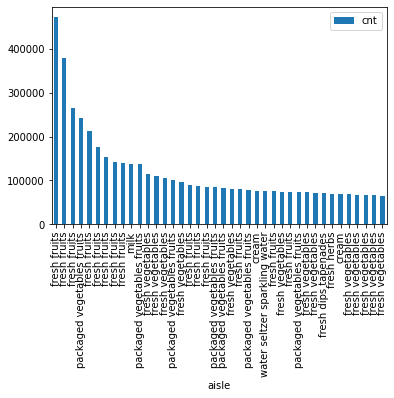

In [0]:
# Pandas DataFrame의 plot.bar 기능을 이용하여 bar chart 시각화
import pandas as pd
import matplotlib.pyplot as plt

# 상위 40개만 bar chart로 표현. 
plt.figure(figsize=(10, 8))
grp_result_pdf.iloc[:40, :].plot.bar(x='aisle', y='cnt', rot=90)
plt.show()

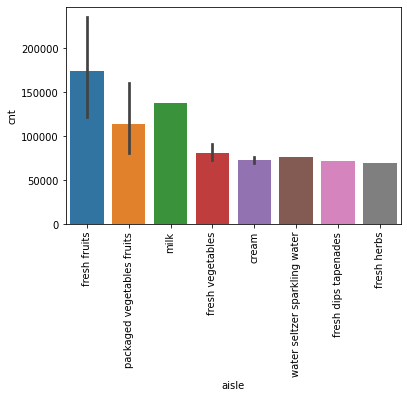

In [0]:
import seaborn as sns

#seaborn을 사용하여 bar chart 시각화
sns.barplot(x="aisle", y="cnt", data=grp_result_pdf.iloc[:40,]) #estimator=sum
plt.xticks(rotation=90)
plt.show()

In [0]:
%sql
select gubun, count(*) from priors_trains group by gubun

gubun count(1) prior 32434489 train 1384617

In [0]:
%sql
-- group by를 product_id, reordered 레벨로 수행하여 개별 상품별로 reordered여부에 따른 건수 확인.  
-- case when then else end 문을 group by의 aggregation 함수에 적용
with 
order_prods_grp as
(
select gubun, product_id, reordered, count(*) cnt
from priors_trains -- trains, priors 
group by gubun, product_id, reordered -- group by를 gubun, product_id, reordered 로 적용
)
-- end of with 절
select a.*, b.product_name, c.aisle, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
order by a.cnt desc limit 100

gubun product_id reordered cnt product_name aisle department prior 24852 1 398609 Banana fresh fruits produce prior 13176 1 315913 Bag of Organic Bananas fresh fruits produce prior 21137 1 205845 Organic Strawberries fresh fruits produce prior 21903 1 186884 Organic Baby Spinach packaged vegetables fruits produce prior 47209 1 170131 Organic Hass Avocado fresh fruits produce prior 47766 1 134044 Organic Avocado fresh fruits produce prior 27845 1 114510 Organic Whole Milk milk dairy eggs prior 47626 1 106255 Large Lemon fresh fruits produce prior 27966 1 105409 Organic Raspberries packaged vegetables fruits produce prior 16797 1 99802 Strawberries fresh fruits produce prior 26209 1 95768 Limes fresh fruits produce prior 22935 1 79072 Organic Yellow Onion fresh vegetables produce prior 24964 1 74663 Organic Garlic fresh vegetables produce prior 24852 0 73956 Banana fresh fruits produce prior 45007 1 72165 Organic Zucchini fresh vegetables produce prior 49683 1 67313 Cucumber Kirby fresh vegetables produce prior 28204 1 63811 Organic Fuji Apple fresh fruits produce prior 13176 0 63537 Bag of Organic Bananas fresh fruits produce prior 39275 1 62922 Organic Blueberries packaged vegetables fruits produce prior 8277 1 62510 Apple Honeycrisp Organic fresh fruits produce prior 5876 1 60536 Organic Lemon fresh fruits produce prior 49235 1 59672 Organic Half & Half cream dairy eggs prior 21137 0 58838 Organic Strawberries fresh fruits produce prior 44632 1 58513 Sparkling Water Grapefruit water seltzer sparkling water beverages prior 45066 1 57818 Honeycrisp Apple fresh fruits produce prior 19057 1 57201 Organic Large Extra Fancy Fuji Apple fresh fruits produce prior 30391 1 56051 Organic Cucumber fresh vegetables produce prior 40706 1 55230 Organic Grape Tomatoes packaged vegetables fruits produce prior 4920 1 55177 Seedless Red Grapes packaged vegetables fruits produce prior 21903 0 55037 Organic Baby Spinach packaged vegetables fruits produce prior 37646 1 53406 Organic Gala Apples fresh fruits produce prior 27086 1 52728 Half & Half cream dairy eggs prior 30489 1 51690 Original Hummus fresh dips tapenades deli prior 42265 1 50472 Organic Baby Carrots packaged vegetables fruits produce prior 21616 1 49798 Organic Baby Arugula packaged vegetables fruits produce prior 28985 1 46841 Michigan Organic Kale fresh vegetables produce prior 17794 1 46572 Carrots fresh vegetables produce prior 47626 0 46402 Large Lemon fresh fruits produce prior 27104 1 45969 Fresh Cauliflower fresh vegetables produce prior 22035 1 45639 Organic Whole String Cheese packaged cheese dairy eggs prior 19660 1 45558 Spring Water water seltzer sparkling water beverages prior 26209 0 44859 Limes fresh fruits produce prior 5077 1 44834 100% Whole Wheat Bread bread bakery prior 35951 1 43875 Organic Unsweetened Almond Milk soy lactosefree dairy eggs prior 47209 0 43453 Organic Hass Avocado fresh fruits produce prior 4605 1 43269 Yellow Onions fresh vegetables produce prior 16797 0 43149 Strawberries fresh fruits produce prior 31717 1 43103 Organic Cilantro fresh herbs produce prior 44359 1 42971 Organic Small Bunch Celery fresh vegetables produce prior 47766 0 42771 Organic Avocado fresh fruits produce prior 41950 1 42261 Organic Tomato Cluster fresh vegetables produce prior 46979 1 41585 Asparagus fresh vegetables produce prior 39877 1 41566 Organic Granny Smith Apple fresh fruits produce prior 8518 1 41329 Organic Red Onion fresh vegetables produce prior 26604 1 40295 Organic Blackberries fresh fruits produce prior 43352 1 39507 Raspberries packaged produce produce prior 5785 1 38544 Organic Reduced Fat 2% Milk milk dairy eggs prior 10749 1 37968 Organic Red Bell Pepper fresh vegetables produce prior 12341 1 37365 Hass Avocados packaged produce produce prior 24838 1 37343 Unsweetened Almondmilk soy lactosefree dairy eggs prior 34126 1 37141 Organic Italian Parsley Bunch fresh herbs produce prior 39275 0 37138 Organic Blueberries packaged vegetables fruits produce prio

In [0]:
%sql
-- 상품별 주문 건수 대비 reorder/no reorder 건수의 비율 구하기.
-- 특정 상품들은 주문 건수가 작아서 reorder/no reorder 비율이 아주 작거나 아주 큼 

with 
-- 상품별 reorder, no reorder및 전체 건수 구하기
order_prods_grp as
(
select product_id 
  , sum(case when reordered=1 then 1 else 0 end) as reordered_cnt -- 상품별 재주문 건수
  , sum(case when reordered=0 then 1 else 0 end) as no_reordered_cnt -- 상품별 재 주문 하지 않은 건수 
  , count(*) prd_total_cnt -- 상품별 건수 
from priors_trains -- trains, priors 
group by product_id -- group by product_id having total_cnt > 100
)
-- end of with 절.
-- 상품별 전체 주문 건수 대비 reorder 및 no reorder 건수 비율 구하기
select a.*
  , reordered_cnt/prd_total_cnt as reordered_pct -- 상품별 재 주문 비율
  , no_reordered_cnt/prd_total_cnt no_reordered_pct -- 상품별 재주문 하지 않은 비율
  , b.product_name, c.aisle_id, c.aisle, d.department_id, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
order by reordered_pct desc limit 1000

product_id reordered_cnt no_reordered_cnt prd_total_cnt reordered_pct no_reordered_pct product_name aisle_id aisle department_id department 6433 65 4 69 0.9420289855072463 0.057971014492753624 Raw Veggie Wrappers 13 prepared meals 20 deli 2075 84 6 90 0.9333333333333333 0.06666666666666667 Serenity Ultimate Extrema Overnight Pads 126 feminine care 11 personal care 43553 12 1 13 0.9230769230769231 0.07692307692307693 Orange Energy Shots 64 energy sports drinks 7 beverages 27740 94 8 102 0.9215686274509803 0.0784313725490196 Chocolate Love Bar 45 candy chocolate 19 snacks 14609 32 3 35 0.9142857142857143 0.08571428571428572 Soy Powder Infant Formula 92 baby food formula 18 babies 13875 41 4 45 0.9111111111111111 0.08888888888888889 Simply Sleep Nighttime Sleep Aid 6 other 2 other 39992 20 2 22 0.9090909090909091 0.09090909090909091 Energy Shot, Grape Flavor 64 energy sports drinks 7 beverages 5868 27 3 30 0.9 0.1 Russian River Valley Reserve Pinot Noir 28 red wines 5 alcohol 36543 62 7 69 0.8985507246376812 0.10144927536231885 Bars Peanut Butter 88 spreads 13 pantry 26093 60 7 67 0.8955223880597015 0.1044776119402985 Soy Crisps Lightly Salted 107 chips pretzels 19 snacks 4212 34 4 38 0.8947368421052632 0.10526315789473684 High Gravity Lager 27 beers coolers 5 alcohol 35604 93 11 104 0.8942307692307693 0.10576923076923077 Maca Buttercups 45 candy chocolate 19 snacks 38438 25 3 28 0.8928571428571429 0.10714285714285714 Almond Orgeat Syrup 29 honeys syrups nectars 13 pantry 38251 99 12 111 0.8918918918918919 0.10810810810810811 Benchbreak Chardonnay 62 white wines 5 alcohol 36801 88 11 99 0.8888888888888888 0.1111111111111111 Organic Blueberry B Mega 31 refrigerated 7 beverages 31418 55 7 62 0.8870967741935484 0.11290322580645161 Sparking Water 115 water seltzer sparkling water 7 beverages 38529 37 5 42 0.8809523809523809 0.11904761904761904 Very Rare Blended Scotch Whisky 124 spirits 5 alcohol 47825 22 3 25 0.88 0.12 Amazake Almond Shake 31 refrigerated 7 beverages 25766 28 4 32 0.875 0.125 Steamfresh Garlic Parm Peas 116 frozen produce 1 frozen 14725 27 4 31 0.8709677419354839 0.12903225806451613 Obsidian Stout 27 beers coolers 5 alcohol 2406 27 4 31 0.8709677419354839 0.12903225806451613 Pure Zero 64 energy sports drinks 7 beverages 10236 114 17 131 0.8702290076335878 0.1297709923664122 Fragrance Free Clay with Natural Odor Eliminator Cat Litter 41 cat food care 8 pets 20598 99 15 114 0.868421052631579 0.13157894736842105 Thousand Island Salad Snax 50 fruit vegetable snacks 19 snacks 15657 39 6 45 0.8666666666666667 0.13333333333333333 Peanut Butter Honey Spread 29 honeys syrups nectars 13 pantry 5457 78 12 90 0.8666666666666667 0.13333333333333333 Classic Carbonated Natural Mineral Water 115 water seltzer sparkling water 7 beverages 41046 64 10 74 0.8648648648648649 0.13513513513513514 G Series Orange Sports Drink 64 energy sports drinks 7 beverages 2142 51 8 59 0.864406779661017 0.13559322033898305 Gourmet French Roast Ground Coffee 26 coffee 7 beverages 35910 19 3 22 0.8636363636363636 0.13636363636363635 Porter 27 beers coolers 5 alcohol 35496 394 63 457 0.862144420131291 0.13785557986870897 Real2 Alkalized Water 500 ml 115 water seltzer sparkling water 7 beverages 700 25 4 29 0.8620689655172413 0.13793103448275862 Jet Fuel Dark Roast Whole Bean Coffee 26 coffee 7 beverages 9292 2580 415 2995 0.8614357262103506 0.13856427378964942 Half And Half Ultra Pasteurized 84 milk 16 dairy eggs 10046 31 5 36 0.8611111111111112 0.1388888888888889 Rawhide Chew, Medium Dogs 40 dog food care 8 pets 16514 31 5 36 0.8611111111111112 0.1388888888888889 No Pulp Orange Juice With Vitamin D And Calcium 31 refrigerated 7 beverages 38393 31 5 36 0.8611111111111112 0.1388888888888889 Condensed Soup Manhattan Clam Chowder 69 soup broth bouillon 15 canned goods 45504 8091 1319 9410 0.8598299681190223 0.14017003188097768 Whole Organic Omega 3 Milk 84 milk 16 dairy eggs 17469 416 68 484 0.859504132231405 0.14049586776859505 Lo-Carb Energy Drink 64 ener

In [0]:
query = """
with 
-- 상품별 reorder, no reorder및 전체 건수 구하기
order_prods_grp as
(
select product_id 
  , sum(case when reordered=1 then 1 else 0 end) as reordered_cnt -- 상품별 재주문 건수
  , sum(case when reordered=0 then 1 else 0 end) as no_reordered_cnt -- 상품별 재 주문 하지 않은 건수 
  , count(*) prd_total_cnt -- 상품별 건수 
from priors_trains -- trains, priors 
group by product_id -- group by product_id having total_cnt > 100
)
-- end of with 절.
-- 상품별 전체 주문 건수 대비 reorder 및 no reorder 건수 비율 구하기
select a.*
  , reordered_cnt/prd_total_cnt as reordered_pct -- 상품별 재 주문 비율
  , no_reordered_cnt/prd_total_cnt no_reordered_pct -- 상품별 재주문 하지 않은 비율
  , b.product_name, c.aisle_id, c.aisle, d.department_id, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
"""
grp_result_sdf = spark.sql(query)
grp_result_pdf = grp_result_sdf.select('*').toPandas()

Out[46]: <AxesSubplot:xlabel='reordered_pct', ylabel='reordered_cnt'>

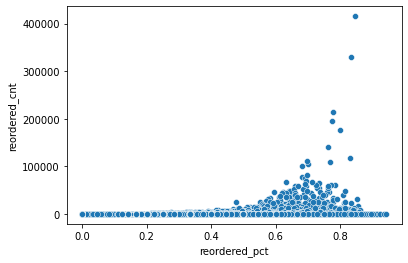

In [0]:
sns.scatterplot(data=grp_result_pdf, x="reordered_pct", y="reordered_cnt")

In [0]:
%sql
-- 상품별 주문 건수 대비 reorder/no reorder 건수의 비율 구하기.
-- 특정 상품들은 주문 건수가 작아서 reorder/no reorder 비율이 아주 작거나 아주 큼 
with 
-- 상품별 reorder, no reorder및 전체 건수 구하기
order_prods_grp as
(
select product_id 
  , sum(case when reordered=1 then 1 else 0 end) as reordered_cnt -- 상품별 재주문 건수
  , sum(case when reordered=0 then 1 else 0 end) as no_reordered_cnt -- 상품별 재 주문 하지 않은 건수 
  , count(*) prd_total_cnt -- 상품별 건수 
from priors_trains -- trains, priors 
group by product_id -- group by product_id having total_cnt > 100
)
-- end of with 절.
-- 상품별 전체 주문 건수 대비 reorder 및 no reorder 건수 비율 구하기
select a.*
  , reordered_cnt/prd_total_cnt as reordered_pct -- 상품별 재 주문 비율
  , no_reordered_cnt/prd_total_cnt no_reordered_pct -- 상품별 재주문 하지 않은 비율
  , b.product_name, c.aisle_id, c.aisle, d.department_id, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
-- 재 주문 건수가 100000건 이상이면서 재주문 비율이 0.7 이상인 상품 추출. 
and reordered_cnt > 100000 and reordered_cnt/prd_total_cnt > 0.7

product_id reordered_cnt no_reordered_cnt prd_total_cnt reordered_pct no_reordered_pct product_name aisle_id aisle department_id department 21137 214448 61129 275577 0.7781781498455967 0.2218218501544033 Organic Strawberries 24 fresh fruits 4 produce 21903 194939 56766 251705 0.7744740867285116 0.22552591327148844 Organic Baby Spinach 123 packaged vegetables fruits 4 produce 13176 329275 65655 394930 0.8337553490491986 0.1662446509508014 Bag of Organic Bananas 24 fresh fruits 4 produce 47209 176173 44704 220877 0.7976068128415362 0.20239318715846377 Organic Hass Avocado 24 fresh fruits 4 produce 47766 140270 43954 184224 0.7614100225812055 0.2385899774187945 Organic Avocado 24 fresh fruits 4 produce 24852 415166 76125 491291 0.84505110006086 0.15494889993913993 Banana 24 fresh fruits 4 produce 27966 109688 32915 142603 0.7691843790102593 0.23081562098974076 Organic Raspberries 123 packaged vegetables fruits 4 produce 27845 118684 24129 142813 0.8310447928409879 0.16895520715901213 Organic Whole Milk 84 milk 16 dairy eggs

In [0]:
%sql
-- 상품별 주문 건수 대비 reorder/no reorder 건수의 비율 구하기. 
-- 상품별 reorder, no reorder및 전체 건수 구하기
with 
order_prods_grp as
(
select product_id 
  , sum(case when reordered=1 then 1 else 0 end) as reordered_cnt -- 상품별 재주문 건수
  , sum(case when reordered=0 then 1 else 0 end) as no_reordered_cnt -- 상품별 재주문 하지 않은 건수
  , sum(reordered) as reordered_cnt_01 -- reordered는 0과 1이므로 상품별 재 주문 건수는 sum(reordered)로도  가능.
  , avg(reordered) as avg_reordered -- reordered는 0과 1이므로 상품별 재 주문 비율은 avg(reordered)로도 가능.
  , count(*) prd_total_cnt -- 상품별 건수 
from priors_trains -- trains, priors 
group by product_id -- group by product_id having total_cnt > 100
)
-- end of with 절.
-- 상품별 전체 주문 건수 대비 reorder 및 no reorder 건수 비율 구하기
select a.*
  , reordered_cnt/prd_total_cnt as reordered_pct -- 상품별 재 주문 비율
  , no_reordered_cnt/prd_total_cnt no_reordered_pct -- 상품별 재주문 하지 않은 비율
  , b.product_name, c.aisle_id, c.aisle, d.department_id, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id

product_id reordered_cnt no_reordered_cnt reordered_cnt_01 avg_reordered prd_total_cnt reordered_pct no_reordered_pct product_name aisle_id aisle department_id department 8075 1087 1404 1087 0.43637093536732235 2491 0.43637093536732235 0.5636290646326776 Small Compostable Waste Bag 60 trash bags liners 17 household 3506 0 16 0 0.0 16 0.0 1.0 Organic Melange Peppercorn 104 spices seasonings 13 pantry 16896 1450 864 1450 0.6266205704407951 2314 0.6266205704407951 0.37337942955920483 Potato Chips Sweet Potato 107 chips pretzels 19 snacks 38996 4178 4781 4178 0.4663466904788481 8959 0.4663466904788481 0.5336533095211519 Grape Tomatoes 83 fresh vegetables 4 produce 15322 280 229 280 0.550098231827112 509 0.550098231827112 0.449901768172888 Sriracha Chicken Big Burrito 38 frozen meals 1 frozen 39527 3373 1447 3373 0.6997925311203319 4820 0.6997925311203319 0.30020746887966804 Chocolate Lowfat Milk 84 milk 16 dairy eggs 47492 3658 3096 3658 0.5416049748297306 6754 0.5416049748297306 0.4583950251702695 Organic Berry Blend 116 frozen produce 1 frozen 36103 338 451 338 0.42839036755386567 789 0.42839036755386567 0.5716096324461344 Extra Light Olive Oil 19 oils vinegars 13 pantry 5385 3021 1613 3021 0.6519205869659042 4634 0.6519205869659042 0.3480794130340958 Country White Bread 112 bread 3 bakery 12044 279 499 279 0.35861182519280205 778 0.35861182519280205 0.6413881748071979 Sweet Garden Peas 116 frozen produce 1 frozen 11190 278 401 278 0.40942562592047127 679 0.40942562592047127 0.5905743740795287 Hardwood Floor Cleaner 114 cleaning products 17 household 49326 641 668 641 0.48968678380443087 1309 0.48968678380443087 0.5103132161955691 Cereal Variety Fun Pack 121 cereal 14 breakfast 11945 2317 964 2317 0.7061871380676623 3281 0.7061871380676623 0.2938128619323377 Organic Gluten & Wheat Free Homestyle Waffles 52 frozen breakfast 1 frozen 30928 32 453 32 0.06597938144329897 485 0.06597938144329897 0.934020618556701 Organic Gluten Free Yellow Cornmeal 17 baking ingredients 13 pantry 47877 4344 1728 4344 0.7154150197628458 6072 0.7154150197628458 0.2845849802371542 Coke Zero 77 soft drinks 7 beverages 33862 602 525 602 0.5341614906832298 1127 0.5341614906832298 0.4658385093167702 All One Hemp Peppermint Castile Soap Bar 25 soap 11 personal care 25084 289 303 289 0.48817567567567566 592 0.48817567567567566 0.5118243243243243 Philadelphia Whipped Cream Cheese Spread with Chives 108 other creams cheeses 16 dairy eggs 38108 1829 1179 1829 0.6080452127659575 3008 0.6080452127659575 0.39195478723404253 Sausage Buns 43 buns rolls 3 bakery 11619 905 650 905 0.5819935691318328 1555 0.5819935691318328 0.4180064308681672 Dairy Free Coconut Milk Chocolate Yogurt Alternative 120 yogurt 16 dairy eggs 39094 1640 1072 1640 0.6047197640117994 2712 0.6047197640117994 0.3952802359882006 Barbeque Potato Chips 107 chips pretzels 19 snacks 15846 103 158 103 0.3946360153256705 261 0.3946360153256705 0.6053639846743295 Original Super Odor Killer Gel Air Freshener 101 air fresheners candles 17 household 32912 339 219 339 0.6075268817204301 558 0.6075268817204301 0.3924731182795699 Baked Whole Grain Wheat Hint of Salt Crackers 78 crackers 19 snacks 39350 154 192 154 0.44508670520231214 346 0.44508670520231214 0.5549132947976878 Cabernet Sauvignon, California, 2005 28 red wines 5 alcohol 40634 549 510 549 0.5184135977337111 1059 0.5184135977337111 0.48158640226628896 Indian Dal Golden Lentil Soups 69 soup broth bouillon 15 canned goods 7747 124 237 124 0.34349030470914127 361 0.34349030470914127 0.6565096952908587 Lemon Mint Foaming Hand Wash 127 body lotions soap 11 personal care 2040 76 277 76 0.21529745042492918 353 0.21529745042492918 0.7847025495750708 Wrap Aluminum Foil Heavy Duty 85 food storage 17 household 26486 584 763 584 0.4335560504825538 1347 0.4335560504825538 0.5664439495174461 Organic Shiitaki Mushrooms 116 frozen produce 1 frozen 10422 3 9 3 0.25 12 0.25 0.75 E.V.O.O. Ceasar Vinaigrette Dressing 89 salad dressing toppings 13 pantry 14719 219 259 

In [0]:
%sql
-- aisle별 주문 reorder의 건수와 비율을 구함. 
-- alias로 바로 group by 할 수 있으나 이후 join등을 위해 product_id로 먼저 group by 한 결과를 다시 alias 로 group by sum()하여 구함. 
with 
-- 상품별 reorder, no reorder 건수 구하기
order_prods_grp as
(
select product_id 
  , sum(case when reordered=1 then 1 else 0 end) as reordered_cnt -- 상품별 재주문 건수
  , sum(case when reordered=0 then 1 else 0 end) as no_reordered_cnt -- 상품별 재주문 하지 않은 건수 
  , count(*) prd_total_cnt -- 상품별 건수 
from priors_trains -- trains, priors 
group by product_id -- group by product_id having total_cnt > 100
), -- end of order_prods_grp
-- 두번째 집합 order_prods_grp_detail
order_prods_grp_detail as
(
select a.* 
  , reordered_cnt/prd_total_cnt as reordered_pct -- 상품별 재 주문 비율
  , no_reordered_cnt/prd_total_cnt no_reordered_pct -- 상품별 재주문 하지 않은 비율
  , b.product_name, c.aisle_id, c.aisle, d.department_id, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
)
-- end of with 절
-- group by를 aisle_id 별로 수행. 
select aisle_id, max(aisle) as aisle 
  , sum(reordered_cnt) aisle_reordered_cnt --상품 중분류별 재 주문 건수 
  , sum(no_reordered_cnt) aisle_no_reordered_cnt --상품 중분류별 재 주문하지 않은 건수. 
  , sum(reordered_cnt)/sum(a.prd_total_cnt) aisle_reordered_pct --상품 중분류별 재 주문 비율
  , sum(no_reordered_cnt)/sum(a.prd_total_cnt) aisle_no_reordered_pct -- 상품 중분류별 재 주문하지 않은 비율
  , sum(prd_total_cnt) aisle_total_cnt -- 상품 중분류별 건수
from order_prods_grp_detail a 
group by aisle_id
order by aisle_total_cnt desc limit 1000
--order by aisle_reordered_pct limit 1000 -- reordered_pct가 높은 순으로 정렬 

aisle_id aisle aisle_reordered_cnt aisle_no_reordered_cnt aisle_reordered_pct aisle_no_reordered_pct aisle_total_cnt 24 fresh fruits 2726251 1066410 0.7188227474061089 0.2811772525938912 3792661 83 fresh vegetables 2123540 1445090 0.5950574870468499 0.4049425129531501 3568630 123 packaged vegetables fruits 1178700 665106 0.639275498615364 0.3607245013846359 1843806 120 yogurt 1034957 472626 0.68650084273967 0.31349915726032995 1507583 21 packaged cheese 598280 423182 0.585709502654039 0.41429049734596096 1021462 84 milk 722128 201531 0.7818123355047696 0.2181876644952304 923659 115 water seltzer sparkling water 640988 237162 0.7299299664066503 0.27007003359334963 878150 107 chips pretzels 444036 309703 0.5891110848715537 0.41088891512844633 753739 91 soy lactosefree 460069 204424 0.692360942854176 0.30763905714582396 664493 112 bread 408010 200459 0.670551827619813 0.329448172380187 608469 31 refrigerated 397213 201896 0.6630062309195822 0.3369937690804177 599109 116 frozen produce 295616 249491 0.5423082073794686 0.4576917926205314 545107 37 ice cream ice 256194 264907 0.491639816465522 0.508360183534478 521101 78 crackers 272645 205785 0.569874380787158 0.430125619212842 478430 3 energy granola bars 283351 190484 0.5979950826764591 0.4020049173235409 473835 86 eggs 333408 138601 0.7063594126383184 0.29364058736168164 472009 96 lunch meat 249963 162124 0.6065782225597993 0.39342177744020074 412087 38 frozen meals 228222 180298 0.5586556349750318 0.44134436502496815 408520 92 baby food formula 233042 162612 0.5890045342647869 0.4109954657352131 395654 16 fresh herbs 203786 190007 0.5174952322666985 0.48250476773330153 393793 121 cereal 225338 168449 0.572233212371155 0.427766787628845 393787 77 soft drinks 238981 134835 0.6393011535086781 0.36069884649132194 373816 67 fresh dips tapenades 225574 145253 0.6082998271431153 0.39170017285688474 370827 69 soup broth bouillon 152715 208858 0.42236284235825133 0.5776371576417487 361573 98 juice nectars 206348 141935 0.5924722136882937 0.4075277863117063 348283 17 baking ingredients 103784 235996 0.3054446995114486 0.6945553004885514 339780 53 cream 226356 104002 0.6851839519551517 0.3148160480448483 330358 108 other creams cheeses 181540 139287 0.5658501310675224 0.43414986893247764 320827 117 nuts seeds dried fruit 165685 153334 0.519357781197985 0.4806422188020149 319019 106 hot dogs bacon sausage 177380 141088 0.5569790371403093 0.4430209628596908 318468 45 candy chocolate 178783 133237 0.5729857060444843 0.42701429395551566 312020 81 canned jarred vegetables 130861 178855 0.4225193402988544 0.5774806597011456 309716 88 spreads 147115 154387 0.48794037850495187 0.5120596214950481 301502 32 packaged produce 200319 89169 0.6919768695075443 0.30802313049245567 289488 59 canned meals beans 142744 139344 0.5060264881880832 0.49397351181191684 282088 131 dry pasta 126283 151652 0.4543616313166748 0.5456383686833253 277935 36 butter 152865 112027 0.577084245654833 0.4229157543451671 264892 93 breakfast bakery 169743 90878 0.6513020823341173 0.34869791766588265 260621 94 tea 136504 122213 0.527618981358009 0.47238101864199106 258717 19 oils vinegars 90055 166031 0.3516592082347336 0.6483407917652664 256086 54 paper goods 135265 120425 0.5290195158199382 0.4709804841800618 255690 61 cookies cakes 134064 109981 0.5493413100043025 0.4506586899956975 244045 52 frozen breakfast 152086 90406 0.6271794533427907 0.3728205466572093 242492 72 condiments 71833 159959 0.30990284392903983 0.6900971560709601 231792 9 pasta sauce 109559 118564 0.4802628406605209 0.5197371593394792 228123 104 spices seasonings 33855 187516 0.15293331104796926 0.8470666889520307 221371 26 coffee 133477 81990 0.6194776926397082 0.38052230736029186 215467 4 instant foods 103244 107360 0.4902281058289491 0.5097718941710508 210604 129 frozen appetizers sides 107122 96330 0.5265222263728053 0.4734777736271946 203452 128 tortillas flat bread 111226 90424 0.5515794693776345 0.4484205306223655 201650 50 fruit vegetable snacks 108

In [0]:
%sql 
-- 상품별 주문 reorder/no reorder 건수와 비율, 그리고 aisle 대비 reorder 건수 차이 비교
with 
-- 첫번째 임시 집합 order_prods_grp
order_prods_grp as
(
select product_id, 
  sum(case when reordered=1 then 1 else 0 end) as reordered_cnt,
  sum(case when reordered=0 then 1 else 0 end) as no_reordered_cnt,
  count(*) prd_total_cnt
from priors_trains -- trains, priors 
group by product_id -- group by product_id having total_cnt > 100
), 
-- 두번째 임시 집합 order_prods_grp_detail
order_prods_grp_detail as
(
select a.*, 
 reordered_cnt/prd_total_cnt reordered_pct, no_reordered_cnt/prd_total_cnt no_reordered_pct,
 b.product_name, c.aisle_id, c.aisle, d.department_id, d.department
from order_prods_grp a, products b, aisles c, depts d 
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
and b.department_id = d.department_id
),
-- 세번째 임시 집합 order_aisle_grp_detail
order_aisle_grp_detail as
(
select aisle_id, max(aisle) aisle, 
  sum(reordered_cnt) aisle_reordered_cnt, 
  sum(no_reordered_cnt) aisle_no_reordered_cnt,
  sum(reordered_cnt)/sum(a.prd_total_cnt) aisle_reordered_pct,
  sum(no_reordered_cnt)/sum(a.prd_total_cnt) aisle_no_reordered_pct,
  sum(prd_total_cnt) aisle_total_cnt
from order_prods_grp_detail a 
group by aisle_id
)
-- end of with 절
select 
  a.*, 
  a.reordered_pct - b.aisle_reordered_pct as reordered_pct_diff_01,
  b.*
from order_prods_grp_detail a, order_aisle_grp_detail b
where a.aisle_id = b.aisle_id 
--and a.prd_total_cnt > 100
order by reordered_pct_diff_01 desc limit 1000

product_id reordered_cnt no_reordered_cnt prd_total_cnt reordered_pct no_reordered_pct product_name aisle_id aisle department_id department reordered_pct_diff_01 aisle_id aisle aisle_reordered_cnt aisle_no_reordered_cnt aisle_reordered_pct aisle_no_reordered_pct aisle_total_cnt 29644 26 5 31 0.8387096774193549 0.16129032258064516 No Calorie Sucralose Sweetener 104 spices seasonings 13 pantry 0.6857763663713856 104 spices seasonings 33855 187516 0.15293331104796926 0.8470666889520307 221371 13142 18 4 22 0.8181818181818182 0.18181818181818182 Cheese Flavor Sprinkles 104 spices seasonings 13 pantry 0.665248507133849 104 spices seasonings 33855 187516 0.15293331104796926 0.8470666889520307 221371 2075 84 6 90 0.9333333333333333 0.06666666666666667 Serenity Ultimate Extrema Overnight Pads 126 feminine care 11 personal care 0.6118584042433857 126 feminine care 6687 14114 0.3214749290899476 0.6785250709100524 20801 49092 13 4 17 0.7647058823529411 0.23529411764705882 Onion Soup & Seasoning Mix 104 spices seasonings 13 pantry 0.6117725713049719 104 spices seasonings 33855 187516 0.15293331104796926 0.8470666889520307 221371 44903 13 3 16 0.8125 0.1875 Celluvisc Lubricant Eye Gel 44 eye ear care 11 personal care 0.5919580970384373 44 eye ear care 2100 7422 0.2205419029615627 0.7794580970384373 9522 14777 37 8 45 0.8222222222222222 0.17777777777777778 Nasal Decongestant Inhaler with Medicated Vapors 11 cold flu allergy 11 personal care 0.5868808860672253 11 cold flu allergy 6450 20957 0.2353413361549969 0.7646586638450031 27407 11986 18 5 23 0.782608695652174 0.21739130434782608 Silhouette for Women L/XL Briefs 118 first aid 11 personal care 0.5867450553051403 118 first aid 2235 9176 0.19586364034703357 0.8041363596529665 11411 3867 14 3 17 0.8235294117647058 0.17647058823529413 Antiperspirant Deodorant, Fresh 80 deodorants 11 personal care 0.5847110617359941 80 deodorants 3743 11930 0.2388183500287118 0.7611816499712882 15673 35324 12 5 17 0.7058823529411765 0.29411764705882354 Sprinkles Butter Flavor Granules 104 spices seasonings 13 pantry 0.5529490418932073 104 spices seasonings 33855 187516 0.15293331104796926 0.8470666889520307 221371 7793 35 7 42 0.8333333333333334 0.16666666666666666 Parma Rosa Sauce Mix 5 marinades meat preparation 13 pantry 0.5520217075594283 5 marinades meat preparation 18402 47013 0.28131162577390506 0.7186883742260949 65415 38438 25 3 28 0.8928571428571429 0.10714285714285714 Almond Orgeat Syrup 29 honeys syrups nectars 13 pantry 0.5332210918469695 29 honeys syrups nectars 25099 44691 0.3596360510101734 0.6403639489898266 69790 47987 12 5 17 0.7058823529411765 0.29411764705882354 Anti-Itch Lotion 118 first aid 11 personal care 0.5100187125941429 118 first aid 2235 9176 0.19586364034703357 0.8041363596529665 11411 43579 21 4 25 0.84 0.16 Body Wash, Restoring, Marula Oil Infused 127 body lotions soap 11 personal care 0.5095956182263139 127 body lotions soap 14176 28729 0.33040438177368603 0.669595618226314 42905 15657 39 6 45 0.8666666666666667 0.13333333333333333 Peanut Butter Honey Spread 29 honeys syrups nectars 13 pantry 0.5070306156564933 29 honeys syrups nectars 25099 44691 0.3596360510101734 0.6403639489898266 69790 45691 23 9 32 0.71875 0.28125 Blackout Berry 132 beauty 11 personal care 0.505891750580945 132 beauty 1374 5081 0.21285824941905498 0.787141750580945 6455 13875 41 4 45 0.9111111111111111 0.08888888888888889 Simply Sleep Nighttime Sleep Aid 6 other 2 other 0.5040586508895073 6 other 15503 22583 0.40705246022160374 0.5929475397783963 38086 43746 22 4 26 0.8461538461538461 0.15384615384615385 Chocolate Brownie Mochi 66 asian foods 6 international 0.49488033134513254 66 asian foods 60986 112628 0.3512735148087136 0.6487264851912864 173614 41901 28 9 37 0.7567567567567568 0.24324324324324326 Moisturizing Lotionized Shave Gel with Vitamin E 55 shave needs 11 personal care 0.4934246493643331 55 shave needs 2864 8012 0.2633321073924237 0.7366678926075764 10876 28735 11 4 15 0.7333333333333333 0.2

### 상품별 고유 사용자 건수 및 이전 주문 이후 현 주문까지 걸리는 일자 분석
* 상품별 고유 사용자가 많으면 여러 사용자가 주문을 하는 상품. 
* 상품별 주문 건수가 높고 고유 사용자 건수도 함께 높으면 다양한 고객으로 부터 많은 선택을 받는 상품. 일반적으로 주문 건수가 높으면 고유 사용자 건수는 상대적으로 낮음.
* 주문 건수가 작은 상품의 경우 서로 다른 개별 user 비율이 높아질 가능성 증대

In [0]:
%sql
describe priors_trains -- describe orders

col_name data_type comment gubun string order_id bigint product_id bigint add_to_cart_order bigint reordered bigint # Partitioning Not partitioned

In [0]:
%sql
drop table if exists order_all_prods

In [0]:
%fs
rm -r dbfs:/user/hive/warehouse/order_all_prods

res2: Boolean = false

In [0]:
%sql
-- orders 테이블을 여러 값으로 분석하기 위해서 orders 테이블과 조인. 
create table order_all_prods
as
select a.order_id, a.product_id, a.add_to_cart_order, a.reordered,
  b.user_id, b.eval_set, b.order_number, b.order_dow, b.order_hour_of_day,
  b.days_since_prior_order
from priors_trains a, orders b
where a.order_id = b.order_id

num_affected_rows num_inserted_rows

In [0]:
%sql
select 'priors_trains' gubun, count(*) from priors_trains 
union all
select 'order_all', count(*) from order_all_prods
union all 
select 'order', count(*) from orders

gubun count(1) priors_trains 33819106 order 3421083 order_all 33819106

In [0]:
%sql
select * from order_all_prods limit 10

order_id product_id add_to_cart_order reordered user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 7 34050 1 0 142903 prior 11 2 14 30.0 7 46802 2 0 142903 prior 11 2 14 30.0 19 42265 1 1 83009 prior 7 5 17 13.0 19 24838 2 1 83009 prior 7 5 17 13.0 19 41540 3 1 83009 prior 7 5 17 13.0 22 23909 1 1 30822 prior 25 1 8 12.0 22 22754 2 1 30822 prior 25 1 8 12.0 22 24852 3 1 30822 prior 25 1 8 12.0 22 28993 4 1 30822 prior 25 1 8 12.0 22 41273 5 1 30822 prior 25 1 8 12.0

In [0]:
%sql 
-- 개별 상품의 주문시 서로 다른 개별 user의 비율 추출. 주문 건수가 작은 상품의 경우 서로 다른 개별 user 비율이 높아질 가능성 증대. 서로 다른 개별 user 비율이 높으면 reordere될 확률 작아짐. reorder 예측이 데이터의 편차에 따라 편향성이 커질 우려.  
select a.*
  , prd_distinct_usr_cnt/prd_total_cnt as prd_usr_ratio -- 상품별 전체 건수 대비 고유 사용자 비율
from (
  select product_id
    , count(distinct user_id) prd_distinct_usr_cnt -- 상품별 고유 사용자 건수
    , count(*) prd_total_cnt 
    , avg(reordered) avg_reordered
  from order_all_prods
  group by product_id
) a 
where prd_total_cnt > 300 order by prd_usr_ratio desc limit 100

product_id prd_distinct_usr_cnt prd_total_cnt avg_reordered prd_usr_ratio 47385 312 319 0.0219435736677116 0.9780564263322884 28741 458 469 0.023454157782515993 0.976545842217484 6288 659 676 0.02514792899408284 0.9748520710059172 44626 613 629 0.025437201907790145 0.9745627980922098 14688 335 344 0.02616279069767442 0.9738372093023255 34592 585 603 0.029850746268656716 0.9701492537313433 40559 299 309 0.032362459546925564 0.9676375404530745 1719 345 357 0.03361344537815126 0.9663865546218487 42421 1050 1088 0.034926470588235295 0.9650735294117647 1658 393 409 0.039119804400977995 0.960880195599022 25089 655 682 0.039589442815249266 0.9604105571847508 39083 469 489 0.0408997955010225 0.9591002044989775 7513 583 608 0.04111842105263158 0.9588815789473685 29736 302 315 0.04126984126984127 0.9587301587301588 37518 418 436 0.04128440366972477 0.9587155963302753 6844 391 409 0.044009779951100246 0.9559902200488998 41348 336 352 0.045454545454545456 0.9545454545454546 15132 310 325 0.046153846153846156 0.9538461538461539 15660 341 358 0.04748603351955307 0.952513966480447 23180 599 630 0.049206349206349205 0.9507936507936507 18634 326 343 0.04956268221574344 0.9504373177842566 37120 935 984 0.049796747967479675 0.9502032520325203 49284 847 893 0.051511758118701005 0.948488241881299 35838 998 1055 0.05402843601895735 0.9459715639810427 45100 361 382 0.0549738219895288 0.9450261780104712 39265 729 772 0.05569948186528497 0.944300518134715 29658 388 411 0.05596107055961071 0.9440389294403893 26764 705 747 0.05622489959839357 0.9437751004016064 35209 497 527 0.056925996204933584 0.9430740037950665 22497 856 909 0.058305830583058306 0.9416941694169417 8203 1680 1785 0.058823529411764705 0.9411764705882353 41958 447 475 0.05894736842105263 0.9410526315789474 40426 445 473 0.05919661733615222 0.9408033826638478 33637 370 395 0.06329113924050633 0.9367088607594937 2380 1643 1755 0.06381766381766382 0.9361823361823362 22923 349 373 0.064343163538874 0.935656836461126 5878 780 834 0.06474820143884892 0.935251798561151 30928 453 485 0.06597938144329897 0.934020618556701 18381 323 346 0.06647398843930635 0.9335260115606936 123 822 881 0.06696935300794551 0.9330306469920545 10107 494 530 0.06792452830188679 0.9320754716981132 4031 663 712 0.06882022471910113 0.9311797752808989 15975 297 319 0.06896551724137931 0.9310344827586207 40470 579 622 0.06913183279742766 0.9308681672025724 48888 384 413 0.07021791767554479 0.9297820823244553 1830 676 728 0.07142857142857142 0.9285714285714286 33792 334 360 0.07222222222222222 0.9277777777777778 47345 448 483 0.07246376811594203 0.927536231884058 24720 511 551 0.07259528130671507 0.9274047186932849 7926 306 330 0.07272727272727272 0.9272727272727272 12113 1781 1921 0.07287870900572618 0.9271212909942738 16834 544 587 0.07325383304940375 0.9267461669505963 26273 303 327 0.07339449541284404 0.926605504587156 6135 871 940 0.07340425531914893 0.926595744680851 7343 300 324 0.07407407407407407 0.9259259259259259 28805 1142 1234 0.07455429497568881 0.9254457050243112 37490 321 347 0.07492795389048991 0.9250720461095101 27400 283 306 0.07516339869281045 0.9248366013071896 11535 348 377 0.07692307692307693 0.9230769230769231 35973 2746 2975 0.07697478991596639 0.9230252100840336 33884 2800 3034 0.07712590639419907 0.922874093605801 14849 562 610 0.07868852459016394 0.921311475409836 5605 1891 2053 0.07890891378470531 0.9210910862152947 25683 405 440 0.07954545454545454 0.9204545454545454 41483 863 938 0.07995735607675906 0.920042643923241 44126 297 323 0.0804953560371517 0.9195046439628483 35333 1028 1119 0.08132260947274352 0.9186773905272565 37458 987 1075 0.08186046511627906 0.9181395348837209 23995 435 474 0.08227848101265822 0.9177215189873418 5006 696 759 0.08300395256916997 0.9169960474308301 6020 1387 1514 0.08388375165125496 0.916116248348745 45801 302 330 0.08484848484848485 0.9151515151515152 45258 538 588 0.08503401360544217 0.9149659863945578 40873 309 338 0.08579881656804733 0.9142011834319527 884 9

In [0]:
%sql
-- 상품별 주문 건수에 따라 상품의 개별 사용자 비율이 어떻게 변하는지 추출. 
with 
order_prods_grp as
-- product_id 레벨로 group by 하여 상품별 서로 다른 개별 사용자 비율을 추출한 결과에 product_name과 중분류명, 대분류명을 알기 위해 aisles와 dept로 조인. 
(
  select product_id
    , count(distinct user_id) prd_distinct_usr_cnt -- 상품별 고유 사용자 건수
    , count(*)  prd_total_cnt -- 상품별 전체 주문 건수 
    , count(distinct user_id)/count(*) as prd_usr_ratio -- 상품별 전체 건수 대비 고유 사용자 비율
  from order_all_prods
  group by product_id
)
-- end of with 절
select floor(prd_total_cnt/1000.0)*1000 as bin, avg(prd_usr_ratio) from order_prods_grp
group by floor(prd_total_cnt/1000.0)*1000 order by 1


bin avg(prd_usr_ratio) 0 0.6532344874235709 1000 0.4764744409433557 2000 0.4578439395079373 3000 0.4390637634505893 4000 0.4226526683536903 5000 0.4170293519210013 6000 0.4153192350203176 7000 0.40118347234655255 8000 0.4065499833058904 9000 0.40187543459858927 10000 0.39975218989932604 11000 0.40387677894275403 12000 0.3802955936079119 13000 0.40680475166431823 14000 0.36516748152354733 15000 0.3790029857411265 16000 0.37792815393043083 17000 0.363422511901145 18000 0.35476462807914333 19000 0.36172640621289226 20000 0.38653054741264875 21000 0.36437397224891127 22000 0.41767460411529916 23000 0.3446276033380732 24000 0.370338861291411 25000 0.37940247474007316 26000 0.377920812165627 27000 0.36108626193917787 28000 0.3468531977106166 29000 0.3871283342972435 30000 0.3237502395274705 31000 0.4122391927967741 32000 0.275261165277676 33000 0.34646448512253386 34000 0.3016007338105141 35000 0.30480200582194056 36000 0.2768437915065197 37000 0.357854373196152 38000 0.30858251334763337 39000 0.31066923513435013 40000 0.3092097645943258 41000 0.3580033438791382 42000 0.29205058963781205 43000 0.340029125540325 44000 0.3573838514521257 46000 0.38843433052075343 47000 0.4305795574288725 48000 0.25762697889182057 49000 0.19350265321829302 50000 0.3094000944733113 51000 0.2470138003015192 52000 0.34492872171380645 54000 0.3816082329298117 56000 0.35921473085818195 57000 0.36743269180889143 58000 0.34058834783972175 59000 0.3392063863188483 60000 0.2774329407219902 61000 0.26310858893839 63000 0.32434145438574136 64000 0.3475978881852947 66000 0.3418378798988433 70000 0.35160629183770187 71000 0.3092551278589869 73000 0.37835728952772074 74000 0.3147181927613336 75000 0.31357684409133185 76000 0.404424859285835 78000 0.23786768473916162 79000 0.22289763781129823 80000 0.3421663995626949 83000 0.27420787325972157 85000 0.30524086818422447 86000 0.33086641766957164 87000 0.26512512604271704 88000 0.34198097141170325 91000 0.3090925030958565 92000 0.28692310176662467 99000 0.3078974811487245 105000 0.36867061489535924 109000 0.31057836434760355 113000 0.3180030894537284 117000 0.3019980291549152 142000 0.19988541407437643 146000 0.31813718805400243 149000 0.3001572484860651 160000 0.3023409124832081 184000 0.2385899774187945 220000 0.20239318715846377 251000 0.22552591327148844 275000 0.2218218501544033 394000 0.1662446509508014 491000 0.15494889993913993

In [0]:
%sql
with 
-- with 구문 첫번째 집합. product_id 레벨로 group by 하여 상품별 서로 다른 개별 사용자 비율을 추출한 결과에 상품명과 상품 중분류명 알기 위해 products와 aisles로 조인
order_prods_grp as
(
  select a.product_id, max(b.product_name) product_name
  , count(distinct user_id) as prd_distinct_usr_cnt -- 상품별 고유 사용자 건수
  , count(*)  as prd_total_cnt  -- 상품별 전체 주문 건수
  , count(distinct user_id)/count(*) as prd_usr_ratio -- 상품별 전체 건수 대비 고유 사용자 비율
  , avg(reordered) as avg_reordered 
  , max(c.aisle_id) as aisle_id, max(c.aisle) as aisle_name
  from order_all_prods a, products b, aisles c
  where a.product_id = b.product_id 
  and b.aisle_id = c.aisle_id
  group by a.product_id
),
-- with 구문 두번째 집합. 상품 중분류별 고유사용자 건수/비율. 상품 중분류명을 알기위해 aisles와 조인. 
order_aisles_grp as
(
select c.aisle_id, max(c.aisle) aisle_name
  , count(distinct a.user_id) aisle_distinct_usr_cnt -- 상품 중분류별 고유 사용자 건수
  , count(*)  aisle_total_cnt -- 상품 중분류별 전체 주문 건수
  , count(distinct a.user_id)/count(*) as aisle_usr_ratio -- 상품 중분류별 전체 건수 대비 고유 사용자 비율
from order_all_prods a, products b, aisles c
where a.product_id = b.product_id 
and b.aisle_id = c.aisle_id
group by c.aisle_id
),
-- with 구문 세번째 집합. 상품 중분류 별 개별 사용자 비율과 상품별 개별 사용자 비율 차이 추출. 
order_prd_alias_grp_diff as
(
select a.*, b.aisle_distinct_usr_cnt, b.aisle_total_cnt, b.aisle_usr_ratio, 
  a.prd_usr_ratio - b.aisle_usr_ratio as usr_ratio_diff
from order_prods_grp a, order_aisles_grp b
where a.aisle_id = b.aisle_id
) 
-- end of with 절
select * from order_prd_alias_grp_diff

product_id product_name prd_distinct_usr_cnt prd_total_cnt prd_usr_ratio avg_reordered aisle_id aisle_name aisle_distinct_usr_cnt aisle_total_cnt aisle_usr_ratio usr_ratio_diff 7 Pure Coconut Water With Orange 18 31 0.5806451612903226 0.41935483870967744 98 juice nectars 78226 348283 0.2246047036461728 0.3560404576441498 19 Gluten Free Quinoa Three Cheese & Mushroom Blend 4 4 1.0 0.0 63 grains rice dried goods 55807 150323 0.3712472475935153 0.6287527524064846 22 Fresh Breath Oral Rinse Mild Mint 26 45 0.5777777777777777 0.4222222222222222 20 oral hygiene 29130 66819 0.4359538454631168 0.14182393231466095 26 Fancy Feast Trout Feast Flaked Wet Cat Food 88 342 0.2573099415204678 0.7426900584795322 41 cat food care 8134 66306 0.12267366452508069 0.13463627699538713 29 Fresh Cut Golden Sweet No Salt Added Whole Kernel Corn 143 228 0.6271929824561403 0.37280701754385964 81 canned jarred vegetables 79025 309716 0.2551531080086273 0.372039874447513 34 Peanut Butter Cereal 2691 6779 0.39696120371736243 0.6030387962826376 121 cereal 79556 393787 0.20202799990858003 0.1949332038087824 50 Pumpkin Muffin Mix 185 298 0.6208053691275168 0.37919463087248323 105 doughs gelatins bake mixes 38074 110847 0.34348245780219583 0.277322911325321 54 24/7 Performance Cat Litter 497 1171 0.42442356959863364 0.5755764304013663 41 cat food care 8134 66306 0.12267366452508069 0.3017499050735529 57 Flat Toothpicks 161 166 0.9698795180722891 0.030120481927710843 111 plates bowls cups flatware 16231 45307 0.35824486282472906 0.61163465524756 65 Organic Red Wine & Olive Oil Dressing Organic 114 162 0.7037037037037037 0.2962962962962963 89 salad dressing toppings 42398 104050 0.40747717443536763 0.2962265292683361 77 Coconut Chocolate Chip Energy Bar 113 306 0.369281045751634 0.630718954248366 3 energy granola bars 65678 473835 0.1386094315531778 0.23067161419845622 94 Organic Blueberry Blitz Fruit & Veggie Smoothie Mashups 290 910 0.31868131868131866 0.6813186813186813 92 baby food formula 26603 395654 0.06723804131893017 0.2514432773623885 110 Uncured Turkey Bologna 10 16 0.625 0.375 100 missing 30950 77396 0.39989146725928987 0.22510853274071013 112 Hot Tomatillo Salsa 51 64 0.796875 0.203125 51 preserved dips spreads 44278 113879 0.38881619965050623 0.40805880034949377 113 Infant's Blend Probiotic 78 113 0.6902654867256637 0.30973451327433627 70 digestion 12095 28078 0.4307642994515279 0.2595011872741358 126 Hot & Spicy Chicken Flavor Ramen Noodles 114 236 0.4830508474576271 0.5169491525423728 4 instant foods 55883 210604 0.26534633720157264 0.21770451025605447 130 Vanilla Milk Chocolate Almond Ice Cream Bars Multi-Pack 1524 4039 0.3773211190888834 0.6226788809111166 37 ice cream ice 92406 521101 0.1773283873951499 0.1999927316937335 136 Simple 20 43 0.46511627906976744 0.5348837209302325 45 candy chocolate 59444 312020 0.1905134286263701 0.27460285044339733 144 Coarse Grind Garlic Powder & Parsley Blend 32 40 0.8 0.2 104 spices seasonings 79264 221371 0.358059547095148 0.44194045290485207 149 Wild Blueberry All Natural Fruit Spread 308 601 0.5124792013311148 0.4875207986688852 88 spreads 85007 301502 0.28194506172430034 0.23053413960681446 155 Artisan Ciabatta 51 61 0.8360655737704918 0.16393442622950818 58 frozen breads doughs 16443 41740 0.39393866794441784 0.442126905826074 167 Sparkling Blush Grape Juice 10 14 0.7142857142857143 0.2857142857142857 77 soft drinks 65580 373816 0.1754339033107197 0.5388518109749946 184 Kisses Milk Chocolate Candy 577 1084 0.5322878228782287 0.4677121771217712 45 candy chocolate 59444 312020 0.1905134286263701 0.3417743942518586 188 Mild El Nino Salsa 74 237 0.31223628691983124 0.6877637130801688 67 fresh dips tapenades 84086 370827 0.22675263667424433 0.0854836502455869 190 Classic Culinary Low Sodium Vegetable Broth 102 158 0.6455696202531646 0.35443037974683544 69 soup broth bouillon 88085 361573 0.2436160885906857 0.4019535316624788 191 Medium Spicy Butter Chicken Simmer Sauce 12 19 0.631578947368421 0.368421052631578

상품별 평균/최소/최대 days_since_prior_order

In [0]:
%sql
select *
from orders a where user_id = 1 

order_id user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 2539329 1 prior 1 2 8 null 2398795 1 prior 2 3 7 15.0 473747 1 prior 3 3 12 21.0 2254736 1 prior 4 4 7 29.0 431534 1 prior 5 4 15 28.0 3367565 1 prior 6 2 7 19.0 550135 1 prior 7 1 9 20.0 3108588 1 prior 8 1 14 14.0 2295261 1 prior 9 1 16 0.0 2550362 1 prior 10 4 8 30.0 1187899 1 train 11 4 8 14.0

In [0]:
%sql
-- 상품별 평균/최소/최대 days_since_prior_order
with 
order_prods_grp as
(
select product_id, 
    avg(days_since_prior_order) as prd_avg_prior_days 
    ,min(days_since_prior_order) as prd_min_prior_days 
    ,max(days_since_prior_order) as prd_max_prior_days
    ,count(*) prd_total_cnt
from order_all_prods group by  product_id)
-- end of with 구문
select * from order_prods_grp

product_id prd_avg_prior_days prd_min_prior_days prd_max_prior_days prd_total_cnt 47492 11.056298160088064 0.0 30.0 6754 11945 10.202889245585874 0.0 30.0 3281 2250 12.58974358974359 1.0 30.0 43 17971 9.985611510791367 0.0 30.0 148 8075 11.318471337579618 0.0 30.0 2491 5385 12.170449282075035 0.0 30.0 4634 16896 9.783448275862069 0.0 30.0 2314 38996 12.281475149590914 0.0 30.0 8959 38510 11.08622620380739 0.0 30.0 1845 47877 11.400420757363253 0.0 30.0 6072 39527 11.016274466681327 0.0 30.0 4820 15057 13.935400516795866 0.0 30.0 1236 39094 9.918359375 0.0 30.0 2712 42969 10.293963254593177 0.0 30.0 405 38108 10.508092892329346 0.0 30.0 3008 38287 13.489247311827956 0.0 30.0 211 29824 12.693832599118943 0.0 30.0 993 35323 11.75609756097561 1.0 30.0 41 28762 10.418118466898955 0.0 30.0 303 11619 10.755390835579515 0.0 30.0 1555 40557 13.161016949152541 0.0 30.0 504 33209 9.443965517241379 0.0 30.0 243 11190 14.019386106623587 0.0 30.0 679 41988 8.75 0.0 30.0 97 29 13.762135922330097 0.0 30.0 228 45410 11.666666666666666 1.0 30.0 31 9458 11.27659574468085 0.0 30.0 1364 26486 11.866877971473851 0.0 30.0 1347 30428 12.794432548179872 0.0 30.0 505 36102 12.369565217391305 0.0 30.0 54 49326 11.39406430338005 0.0 30.0 1309 40634 12.182730923694779 0.0 30.0 1059 44342 13.954545454545455 0.0 30.0 501 6721 10.917808219178083 0.0 30.0 845 11434 7.590909090909091 0.0 30.0 111 2040 12.206686930091186 0.0 30.0 353 17703 13.304259634888439 0.0 30.0 550 17979 13.214180206794682 0.0 30.0 718 8484 13.452702702702704 0.0 30.0 329 36103 12.654054054054054 0.0 30.0 789 7225 9.422442244224422 0.0 30.0 326 14719 12.030837004405287 0.0 30.0 478 25826 13.0 1.0 30.0 217 12044 14.53306342780027 0.0 30.0 778 33862 12.096532333645735 0.0 30.0 1127 10156 7.416666666666667 1.0 30.0 42 39256 13.58974358974359 1.0 30.0 205 15322 13.330508474576272 0.0 30.0 509 32667 8.880239520958083 0.0 30.0 178 40436 13.155172413793103 0.0 30.0 127 32571 16.11111111111111 3.0 30.0 20 25084 13.03290676416819 0.0 30.0 592 32912 12.651923076923078 0.0 30.0 558 32954 11.69767441860465 0.0 30.0 46 28242 12.365646258503402 0.0 30.0 640 15663 13.153846153846153 0.0 30.0 164 39713 6.666666666666667 1.0 30.0 13 23116 7.882882882882883 0.0 30.0 111 1950 12.51578947368421 0.0 30.0 311 26 10.780185758513932 0.0 30.0 342 19771 11.166666666666666 7.0 22.0 7 4590 11.513761467889909 0.0 30.0 113 22129 12.858513189448441 0.0 30.0 452 19907 5.7368421052631575 0.0 17.0 40 16530 10.436842105263159 0.0 30.0 204 41862 10.844660194174757 0.0 30.0 220 18196 12.615635179153095 0.0 30.0 330 2509 10.187692307692307 0.0 30.0 343 48280 7.516129032258065 0.0 30.0 134 27651 11.263636363636364 0.0 30.0 117 30928 10.867713004484305 0.0 30.0 485 22245 12.251396648044693 0.0 30.0 190 21209 10.551724137931034 1.0 30.0 31 7747 13.945945945945946 0.0 30.0 361 42852 11.4375 1.0 30.0 18 11567 12.323529411764707 3.0 30.0 36 2453 11.779141104294478 1.0 30.0 180 15846 12.12295081967213 0.0 30.0 261 13452 11.028747433264886 0.0 30.0 513 31156 11.333333333333334 0.0 30.0 116 19979 13.0 2.0 30.0 28 31762 17.482993197278912 0.0 30.0 162 22429 12.495 0.0 30.0 211 2214 14.48447204968944 0.0 30.0 179 39350 11.873417721518987 0.0 30.0 346 9945 11.4421768707483 0.0 30.0 155 37521 8.441666666666666 0.0 30.0 123 15371 13.294117647058824 2.0 30.0 21 18348 11.875 0.0 30.0 270 11276 12.979166666666666 0.0 30.0 104 46424 11.671641791044776 0.0 30.0 74 39627 12.6 0.0 30.0 51 17043 14.658536585365853 5.0 30.0 41 29089 10.362068965517242 1.0 30.0 61 39104 11.17142857142857 0.0 30.0 42 14117 11.9601593625498 0.0 30.0 266 37098 11.373626373626374 0.0 30.0 103 15237 10.39622641509434 1.0 30.0 55 10871 10.0 0.0 30.0 21 18628 10.901234567901234 0.0 30.0 87 41424 12.339622641509434 0.0 30.0 113 23506 12.35820895522388 1.0 30.0 71 35148 12.447916666666666 0.0 30.0 101 9968 13.370786516853933 0.0 30.0 94 48763 6.704545454545454 1.0 30.0 89 21342 10.68 1.0 30.0 29 40132 6.870967741935484 0.0 30.0 64 25207 13.128205128205128 0.0 30.0 42 22165 1

In [0]:
%sql
-- 상품별 평균/최소/최대 days_since_prior_order
-- instacart는 30일 마다 자동 주문 설정 기능이 있음. 
with 
order_prods_grp as
(
select product_id, 
    avg(days_since_prior_order) as prd_avg_prior_days 
    ,min(days_since_prior_order) as prd_min_prior_days 
    ,max(days_since_prior_order) as prd_max_prior_days
    ,count(*) prd_total_cnt
from order_all_prods group by  product_id)
-- end of with 구문
select floor(prd_max_prior_days/1.0)*1 as bin, count(*) bin_cnt
from order_prods_grp group by floor(prd_max_prior_days/1.0)*1 order by 1

bin bin_cnt null 26 0 4 1 2 2 14 3 29 4 29 5 39 6 74 7 138 8 156 9 127 10 137 11 117 12 134 13 195 14 311 15 253 16 242 17 199 18 193 19 220 20 216 21 309 22 253 23 240 24 226 25 205 26 200 27 261 28 354 29 264 30 44518

상품별 평균 요일, 요일별 주문 건수

In [0]:
%sql
select * from order_all_prods where user_id = 1

order_id product_id add_to_cart_order reordered user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 550135 196 1 1 1 prior 7 1 9 20.0 550135 10258 2 1 1 prior 7 1 9 20.0 550135 12427 3 1 1 prior 7 1 9 20.0 550135 25133 4 1 1 prior 7 1 9 20.0 550135 13032 5 1 1 prior 7 1 9 20.0 2254736 196 1 1 1 prior 4 4 7 29.0 2254736 12427 2 1 1 prior 4 4 7 29.0 2254736 10258 3 1 1 prior 4 4 7 29.0 2254736 25133 4 1 1 prior 4 4 7 29.0 2254736 26405 5 1 1 prior 4 4 7 29.0 2398795 196 1 1 1 prior 2 3 7 15.0 2398795 10258 2 0 1 prior 2 3 7 15.0 2398795 12427 3 1 1 prior 2 3 7 15.0 2398795 13176 4 0 1 prior 2 3 7 15.0 2398795 26088 5 1 1 prior 2 3 7 15.0 2398795 13032 6 0 1 prior 2 3 7 15.0 2550362 196 1 1 1 prior 10 4 8 30.0 2550362 46149 2 1 1 prior 10 4 8 30.0 2550362 39657 3 0 1 prior 10 4 8 30.0 2550362 38928 4 0 1 prior 10 4 8 30.0 2550362 25133 5 1 1 prior 10 4 8 30.0 2550362 10258 6 1 1 prior 10 4 8 30.0 2550362 35951 7 0 1 prior 10 4 8 30.0 2550362 13032 8 1 1 prior 10 4 8 30.0 2550362 12427 9 1 1 prior 10 4 8 30.0 1187899 196 1 1 1 train 11 4 8 14.0 1187899 25133 2 1 1 train 11 4 8 14.0 1187899 38928 3 1 1 train 11 4 8 14.0 1187899 26405 4 1 1 train 11 4 8 14.0 1187899 39657 5 1 1 train 11 4 8 14.0 1187899 10258 6 1 1 train 11 4 8 14.0 1187899 13032 7 1 1 train 11 4 8 14.0 1187899 26088 8 1 1 train 11 4 8 14.0 1187899 27845 9 0 1 train 11 4 8 14.0 1187899 49235 10 1 1 train 11 4 8 14.0 1187899 46149 11 1 1 train 11 4 8 14.0 2539329 196 1 0 1 prior 1 2 8 null 2539329 14084 2 0 1 prior 1 2 8 null 2539329 12427 3 0 1 prior 1 2 8 null 2539329 26088 4 0 1 prior 1 2 8 null 2539329 26405 5 0 1 prior 1 2 8 null 2295261 49235 1 1 1 prior 9 1 16 0.0 2295261 46149 2 1 1 prior 9 1 16 0.0 2295261 25133 3 1 1 prior 9 1 16 0.0 2295261 196 4 1 1 prior 9 1 16 0.0 2295261 10258 5 1 1 prior 9 1 16 0.0 2295261 12427 6 1 1 prior 9 1 16 0.0 431534 196 1 1 1 prior 5 4 15 28.0 431534 12427 2 1 1 prior 5 4 15 28.0 431534 10258 3 1 1 prior 5 4 15 28.0 431534 25133 4 1 1 prior 5 4 15 28.0 431534 10326 5 0 1 prior 5 4 15 28.0 431534 17122 6 0 1 prior 5 4 15 28.0 431534 41787 7 0 1 prior 5 4 15 28.0 431534 13176 8 1 1 prior 5 4 15 28.0 3367565 196 1 1 1 prior 6 2 7 19.0 3367565 12427 2 1 1 prior 6 2 7 19.0 3367565 10258 3 1 1 prior 6 2 7 19.0 3367565 25133 4 1 1 prior 6 2 7 19.0 473747 196 1 1 1 prior 3 3 12 21.0 473747 12427 2 1 1 prior 3 3 12 21.0 473747 10258 3 1 1 prior 3 3 12 21.0 473747 25133 4 0 1 prior 3 3 12 21.0 473747 30450 5 0 1 prior 3 3 12 21.0 3108588 12427 1 1 1 prior 8 1 14 14.0 3108588 196 2 1 1 prior 8 1 14 14.0 3108588 10258 3 1 1 prior 8 1 14 14.0 3108588 25133 4 1 1 prior 8 1 14 14.0 3108588 46149 5 0 1 prior 8 1 14 14.0 3108588 49235 6 0 1 prior 8 1 14 14.0

In [0]:
%sql
-- 상품별 요일/시간 평균 값은 아님. 단순히 상품별로 주문된 order_dow/order_hour 값을 평균
-- 요일별 상품 주문 건수 
SELECT product_id, 
    avg(order_dow) prd_avg_order_dow,
    -- 요일 별 상품 주문 건수 
    sum(case when order_dow=0 then 1 end) prd_cnt_order_dow_0,
    sum(case when order_dow=1 then 1 end) prd_cnt_order_dow_1,
    sum(case when order_dow=2 then 1 end) prd_cnt_order_dow_2,
    sum(case when order_dow=3 then 1 end) prd_cnt_order_dow_3,
    sum(case when order_dow=4 then 1 end) prd_cnt_order_dow_4,
    sum(case when order_dow=5 then 1 end) prd_cnt_order_dow_5,
    sum(case when order_dow=6 then 1 end) prd_cnt_order_dow_6,
    avg(order_hour_of_day) prd_avg_order_hour_of_day
FROM 
    order_all_prods GROUP BY product_id

product_id prd_avg_order_dow prd_cnt_order_dow_0 prd_cnt_order_dow_1 prd_cnt_order_dow_2 prd_cnt_order_dow_3 prd_cnt_order_dow_4 prd_cnt_order_dow_5 prd_cnt_order_dow_6 prd_avg_order_hour_of_day 47492 2.6174119040568553 1530 1126 844 776 763 806 909 13.758069292271246 11945 2.6348674184699785 659 590 481 364 376 369 442 13.416031697653155 2250 2.953488372093023 4 5 13 5 5 5 6 14.0 17971 2.5675675675675675 34 33 10 18 14 17 22 13.283783783783784 8075 2.7663588920112403 477 391 366 306 280 296 375 13.476515455640305 5385 2.760897712559344 807 835 665 558 547 565 657 13.362753560638756 16896 2.832324978392394 397 375 320 291 301 318 312 13.595937770095073 38996 2.7267552182163186 1934 1507 1051 937 1032 1107 1391 13.540462105145664 38510 2.77289972899729 396 288 216 208 200 250 287 13.288346883468835 47877 2.8509552042160737 757 1208 849 875 788 942 653 13.100461133069828 39527 2.6103734439834025 970 870 663 596 582 564 575 13.151659751037345 15057 3.0655339805825244 199 174 150 152 161 185 215 13.47653721682848 39094 2.812315634218289 524 443 334 306 338 356 411 13.617256637168142 42969 2.748148148148148 67 84 53 42 44 69 46 13.577777777777778 38108 2.811502659574468 661 430 331 330 366 429 461 13.506981382978724 38287 3.018957345971564 37 27 28 27 27 25 40 13.246445497630331 29824 2.906344410876133 165 153 122 150 118 143 142 13.812688821752266 35323 2.6341463414634148 7 8 6 5 5 7 3 12.24390243902439 28762 2.778877887788779 54 44 53 39 33 37 43 13.267326732673267 11619 2.873311897106109 275 246 201 193 191 217 232 13.52733118971061 40557 2.6904761904761907 104 81 73 60 53 61 72 13.5 33209 2.8106995884773665 31 47 43 24 40 30 28 12.781893004115226 11190 2.8321060382916055 75 142 102 111 79 92 78 12.565537555228277 41988 3.247422680412371 11 15 14 11 11 15 20 12.97938144329897 29 2.574561403508772 51 44 31 19 23 28 32 13.368421052631579 45410 2.5806451612903225 4 7 6 4 2 7 1 13.225806451612904 9458 2.8658357771260996 259 204 167 168 165 199 202 13.647360703812316 26486 2.9079435783221976 245 193 175 170 162 196 206 13.391982182628063 30428 2.756435643564356 100 84 61 60 67 60 73 13.306930693069306 36102 2.5555555555555554 9 12 9 2 11 8 3 13.481481481481481 49326 2.831168831168831 175 245 191 187 166 216 129 12.97860962566845 40634 2.696883852691218 211 190 134 124 117 140 143 13.776203966005665 44342 2.75249500998004 99 79 73 69 40 59 82 13.538922155688622 6721 2.7964497041420118 188 116 113 83 99 100 146 13.620118343195266 11434 2.8828828828828827 8 26 16 19 14 19 9 14.252252252252251 2040 2.8895184135977336 67 42 45 55 48 45 51 13.974504249291785 17703 2.3927272727272726 132 108 77 51 62 67 53 12.847272727272728 17979 2.9247910863509747 167 95 75 74 58 93 156 13.759052924791087 8484 2.8996960486322187 66 38 37 53 42 43 50 13.781155015197568 36103 2.826362484157161 131 130 112 115 88 99 114 13.409378960709759 7225 3.1319018404907975 55 35 42 41 47 45 61 14.484662576687116 14719 3.010460251046025 77 67 66 58 64 66 80 13.284518828451883 25826 2.7465437788018434 41 37 31 25 26 24 33 13.387096774193548 12044 2.8123393316195373 163 109 105 83 95 98 125 13.038560411311053 33862 2.770186335403727 242 178 122 138 126 144 177 13.566104702750666 10156 2.8095238095238093 10 3 6 6 7 3 7 14.761904761904763 39256 2.9170731707317072 37 23 34 25 27 30 29 13.736585365853658 15322 2.506876227897839 122 93 71 50 48 51 74 14.129666011787819 32667 3.056179775280899 27 14 36 24 24 28 25 13.365168539325843 40436 2.921259842519685 19 20 22 13 15 20 18 13.409448818897637 32571 2.15 4 5 3 3 2 3 null 13.15 25084 2.893581081081081 106 98 70 65 72 94 87 13.243243243243244 32912 2.639784946236559 98 100 74 88 80 67 51 13.519713261648745 32954 2.869565217391304 9 7 6 5 3 10 6 13.173913043478262 28242 2.846875 124 92 72 91 88 77 96 13.9109375 15663 2.823170731707317 27 28 24 24 14 23 24 14.195121951219512 39713 3.3076923076923075 2 2 1 1 null 6 1 8.923076923076923 23116 3.009009009009009 16 13 17 18 16 17 14 14.306306306306306 1950 2.9581993569131835 59 40 37 

In [0]:
%sql
select order_dow, reordered, count(*) as cnt
from order_all_prods group by order_dow, reordered order by 1

order_dow reordered cnt 0 1 3831900 0 0 2701792 1 0 2327173 1 1 3544661 2 1 2582006 2 0 1796354 3 0 1654221 3 1 2344277 4 0 1612076 4 1 2330620 5 0 1772555 5 1 2613888 6 0 1999575 6 1 2708008

In [0]:
%sql
select order_hour_of_day, reordered, count(*) as cnt
from order_all_prods group by order_hour_of_day, reordered order by 1

order_hour_of_day reordered cnt 0 1 129003 0 0 99028 1 0 53646 1 1 67766 2 1 40368 2 0 32292 3 0 23627 3 1 30132 4 0 23825 4 1 31889 5 0 35976 5 1 55933 6 0 109844 6 1 192798 7 0 329832 7 1 598407 8 1 1130174 8 0 657185 9 1 1580305 9 0 970264 10 0 1148406 10 1 1726499 11 0 1176430 11 1 1676271 12 0 1148701 12 1 1583898 13 0 1165933 13 1 1612121 14 0 1175630 14 1 1635288 15 1 1615183 15 0 1165548 16 0 1114542 16 1 1533153 17 1 1258378 17 0 928031 18 0 730454 18 1 983991 19 0 560039 19 1 757537 20 1 593323 20 0 424635 21 0 339619 21 1 491564 22 1 387990 22 0 274063 23 0 176196 23 1 243389

### 사용자별(USER_ID)별 주문 건수 관련 분석
* 사용자가 주문을 많이 하는 성향인지, 1회 주문시 많은 상품을 주문하는 성향인지, 특정 상품만 주로 주문하는지에 대한 속성 분석
* 사용자별 주문/상품 건수, 고유주문/고유상품 건수 분석
* 사용자별 1회 주문 시 상품 건수, 고유 주문상품 대비 주문 상품 건수, 사용자별 주문 상품 건수 대비 고유 상품 건수 비율

In [0]:
%sql
-- 사용자별 1회 주문시 평균 주문 상품 건수, 1회 주문시 평균 고유 주문 상품 건수, 사용자별 총 상품 건수 대비 고유 상품 건수 비율 
select user_id, usr_total_cnt, prd_distinct_cnt, order_distinct_cnt
  , usr_total_cnt/order_distinct_cnt as usr_avg_prd_cnt -- 사용자별 1회 주문시 주문 상품 건수(평균)
  , usr_total_cnt/prd_distinct_cnt as usr_avg_unq_prd_cnt -- 사용자별 고유 주문 상품 대비 주문 상품 건수(평균) 
  , prd_distinct_cnt/usr_total_cnt as usr_unq_prd_ratio --사용자별 주문 총 상품 건수 대비 고유 상품 건수 비율
from (
  select user_id
    , count(*) as usr_total_cnt -- 사용자별 상품 주문 건수
    ,count(distinct product_id) prd_distinct_cnt -- 사용자별 고유 상품 주문 건수 
    ,count(distinct order_id) order_distinct_cnt -- 사용자별 고유 주문 건수
  from order_all_prods a group by user_id -- where order_id in (2539329, 2398795, 473747)
)

user_id usr_total_cnt prd_distinct_cnt order_distinct_cnt usr_avg_prd_cnt usr_avg_unq_prd_cnt usr_unq_prd_ratio 148 110 88 8 13.75 1.25 0.8 463 85 62 7 12.142857142857142 1.3709677419354838 0.7294117647058823 471 147 91 7 21.0 1.6153846153846154 0.6190476190476191 496 452 108 82 5.512195121951219 4.185185185185185 0.23893805309734514 833 234 141 12 19.5 1.6595744680851063 0.6025641025641025 1088 217 148 16 13.5625 1.4662162162162162 0.6820276497695853 1238 321 119 29 11.068965517241379 2.697478991596639 0.3707165109034268 1342 52 28 7 7.428571428571429 1.8571428571428572 0.5384615384615384 1580 82 42 10 8.2 1.9523809523809523 0.5121951219512195 1591 39 34 4 9.75 1.1470588235294117 0.8717948717948718 1645 112 63 8 14.0 1.7777777777777777 0.5625 1829 47 38 7 6.714285714285714 1.236842105263158 0.8085106382978723 1959 26 26 5 5.2 1.0 1.0 2122 21 9 11 1.9090909090909092 2.3333333333333335 0.42857142857142855 2142 86 24 13 6.615384615384615 3.5833333333333335 0.27906976744186046 2366 78 30 30 2.6 2.6 0.38461538461538464 2659 169 137 17 9.941176470588236 1.2335766423357664 0.8106508875739645 2866 183 33 38 4.815789473684211 5.545454545454546 0.18032786885245902 3175 110 55 10 11.0 2.0 0.5 3749 180 53 26 6.923076923076923 3.3962264150943398 0.29444444444444445 3794 1510 359 87 17.35632183908046 4.206128133704736 0.23774834437086093 3918 208 96 12 17.333333333333332 2.1666666666666665 0.46153846153846156 3997 28 21 4 7.0 1.3333333333333333 0.75 4101 102 62 6 17.0 1.6451612903225807 0.6078431372549019 4519 38 31 4 9.5 1.2258064516129032 0.8157894736842105 4818 72 39 17 4.235294117647059 1.8461538461538463 0.5416666666666666 4900 232 83 18 12.88888888888889 2.7951807228915664 0.3577586206896552 4935 49 43 6 8.166666666666666 1.1395348837209303 0.8775510204081632 5156 279 115 30 9.3 2.4260869565217393 0.4121863799283154 5300 96 74 8 12.0 1.2972972972972974 0.7708333333333334 5518 94 56 12 7.833333333333333 1.6785714285714286 0.5957446808510638 5803 137 77 4 34.25 1.7792207792207793 0.5620437956204379 6336 191 91 18 10.61111111111111 2.098901098901099 0.47643979057591623 6357 44 31 6 7.333333333333333 1.4193548387096775 0.7045454545454546 6397 8 6 4 2.0 1.3333333333333333 0.75 6466 146 103 7 20.857142857142858 1.4174757281553398 0.7054794520547946 6620 575 98 21 27.38095238095238 5.86734693877551 0.17043478260869566 6654 90 49 9 10.0 1.836734693877551 0.5444444444444444 6658 154 91 12 12.833333333333334 1.6923076923076923 0.5909090909090909 7240 89 69 8 11.125 1.289855072463768 0.7752808988764045 7253 21 16 5 4.2 1.3125 0.7619047619047619 7340 41 25 10 4.1 1.64 0.6097560975609756 7554 302 124 17 17.764705882352942 2.435483870967742 0.4105960264900662 7754 239 131 18 13.277777777777779 1.8244274809160306 0.5481171548117155 7833 116 53 28 4.142857142857143 2.188679245283019 0.45689655172413796 7880 172 108 9 19.11111111111111 1.5925925925925926 0.627906976744186 7982 43 19 18 2.388888888888889 2.263157894736842 0.4418604651162791 7993 114 78 10 11.4 1.4615384615384615 0.6842105263157895 8086 494 73 100 4.94 6.767123287671233 0.14777327935222673 8389 64 51 9 7.111111111111111 1.2549019607843137 0.796875 8592 56 38 5 11.2 1.4736842105263157 0.6785714285714286 8638 171 87 7 24.428571428571427 1.9655172413793103 0.5087719298245614 9376 446 172 37 12.054054054054054 2.5930232558139537 0.38565022421524664 9427 73 47 6 12.166666666666666 1.553191489361702 0.6438356164383562 9465 257 119 29 8.862068965517242 2.1596638655462184 0.46303501945525294 9852 247 59 46 5.369565217391305 4.186440677966102 0.2388663967611336 9900 37 30 7 5.285714285714286 1.2333333333333334 0.8108108108108109 10206 71 42 6 11.833333333333334 1.6904761904761905 0.5915492957746479 10362 158 80 10 15.8 1.975 0.5063291139240507 10623 105 69 9 11.666666666666666 1.5217391304347827 0.6571428571428571 10817 397 206 29 13.689655172413794 1.9271844660194175 0.5188916876574308 11033 52 36 11 4.7272727272727275 1.4444444444444444 0.6923076923076923 11141 13 11 5 2.6 1.1818181818181819 

In [0]:
%sql
with
-- 사용자별 1회 주문시 평균 주문 상품 건수, 1회 주문시 평균 고유 주문 상품 건수, 사용자별 총 상품 건수 대비 고유 상품 건수 비율 
order_usr_grp as
(
  -- 사용자별 1회 주문시 평균 주문 상품 건수, 1회 주문시 평균 고유 주문 상품 건수, 사용자별 총 상품 건수 대비 고유 상품 건수 비율 
  select usr_total_cnt, prd_distinct_cnt, order_distinct_cnt
    , usr_total_cnt/order_distinct_cnt as usr_avg_prd_cnt -- 사용자별 1회 주문시 주문 상품 건수(평균)
    , usr_total_cnt/prd_distinct_cnt as usr_avg_unq_prd_cnt -- 사용자별 고유 주문 상품 대비 주문 상품 건수(평균) 
    , prd_distinct_cnt/usr_total_cnt as usr_unq_prd_ratio --사용자별 주문 총 상품 건수 대비 고유 상품 건수 비율
  from (
    select user_id
      , count(*) as usr_total_cnt -- 사용자별 상품 주문 건수
      ,count(distinct product_id) prd_distinct_cnt -- 사용자별 고유 상품 주문 건수 
      ,count(distinct order_id) order_distinct_cnt -- 사용자별 고유 주문 건수
    from order_all_prods a group by user_id -- where order_id in (2539329, 2398795, 473747)
  )
)
-- end of with 구문
select avg(usr_avg_prd_cnt), min(usr_avg_prd_cnt), max(usr_avg_prd_cnt)
from order_usr_grp

avg(usr_avg_prd_cnt) min(usr_avg_prd_cnt) max(usr_avg_prd_cnt) 9.984526700309306 1.0 60.5

In [0]:
%sql
with
-- 사용자별 1회 주문시 평균 주문 상품 건수, 1회 주문시 평균 고유 주문 상품 건수, 사용자별 총 상품 건수 대비 고유 상품 건수 비율
-- 개별 select 값들의 histogram 확인. 
order_usr_grp as
(
 -- 사용자별 1회 주문시 평균 주문 상품 건수, 1회 주문시 평균 고유 주문 상품 건수, 사용자별 총 상품 건수 대비 고유 상품 건수 비율 
  select usr_total_cnt, prd_distinct_cnt, order_distinct_cnt
    , usr_total_cnt/order_distinct_cnt as usr_avg_prd_cnt -- 사용자별 1회 주문시 주문 상품 건수(평균)
    , usr_total_cnt/prd_distinct_cnt as usr_avg_unq_prd_cnt -- 사용자별 고유 주문 상품 대비 주문 상품 건수(평균) 
    , prd_distinct_cnt/usr_total_cnt as usr_unq_prd_ratio --사용자별 주문 총 상품 건수 대비 고유 상품 건수 비율
  from (
    select user_id
      , count(*) as usr_total_cnt -- 사용자별 상품 주문 건수
      ,count(distinct product_id) prd_distinct_cnt -- 사용자별 고유 상품 주문 건수 
      ,count(distinct order_id) order_distinct_cnt -- 사용자별 고유 주문 건수
    from order_all_prods a group by user_id -- where order_id in (2539329, 2398795, 473747)
  )
)
-- end of with 구문
select floor(usr_avg_prd_cnt/5.0)*5 as bin, count(*) bin_cnt
from order_usr_grp group by floor(usr_avg_prd_cnt/5.0)*5 order by 1 

bin bin_cnt 0 39161 5 78697 10 52853 15 22584 20 8477 25 2973 30 960 35 329 40 109 45 42 50 15 55 7 60 2

#### 사용자별 reordered 관련 속성 분석
* 사용자별 reordered 총합(사용자별 REORDERED된 상품 건수)
* 사용자별 reordered 비율(사용자별 전체 주문 건수 대비 사용자별 REORDERED된 상품 건수)

In [0]:
%sql
select user_id, count(*) usr_total_cnt
, sum(reordered) usr_reord_cnt -- 사용자별 reordered된 상품 건수 -- sum(case when reordered=1 then 1 else 0 end)
, sum(case when reordered = 0 then 1 else 0 end) as usr_no_reord_cnt -- 사용자별 reorder 하지 않은 상품 건수. count(*) - sum(reoredred)와 동일.
, avg(reordered) usr_reord_avg -- 사용자별 reordered 비율
from order_all_prods group by user_id

user_id usr_total_cnt usr_reord_cnt usr_no_reord_cnt usr_reord_avg 15447 366 325 41 0.8879781420765027 143153 109 73 36 0.6697247706422018 40574 573 463 110 0.8080279232111692 18866 179 143 36 0.7988826815642458 101475 26 13 13 0.5 25517 589 440 149 0.7470288624787776 188264 187 113 74 0.6042780748663101 28759 164 21 143 0.12804878048780488 129791 202 128 74 0.6336633663366337 87338 81 30 51 0.37037037037037035 70355 943 752 191 0.7974549310710498 167532 42 6 36 0.14285714285714285 48875 134 71 63 0.5298507462686567 139379 1417 1236 181 0.8722653493295696 92317 603 481 122 0.7976782752902156 160563 177 59 118 0.3333333333333333 60769 545 418 127 0.7669724770642202 199855 537 349 188 0.6499068901303539 156645 557 431 126 0.7737881508078994 146036 82 40 42 0.4878048780487805 8086 494 421 73 0.8522267206477733 88599 87 27 60 0.3103448275862069 197603 240 92 148 0.38333333333333336 35689 1243 1024 219 0.8238133547868061 36131 74 19 55 0.25675675675675674 21700 116 56 60 0.4827586206896552 167919 265 211 54 0.7962264150943397 135000 67 32 35 0.47761194029850745 150383 100 19 81 0.19 74775 15 0 15 0.0 13623 620 398 222 0.6419354838709678 18800 28 15 13 0.5357142857142857 94819 105 48 57 0.45714285714285713 2866 183 150 33 0.819672131147541 133590 603 451 152 0.7479270315091211 170096 641 400 241 0.62402496099844 164603 238 159 79 0.6680672268907563 56110 409 264 145 0.6454767726161369 147524 762 502 260 0.6587926509186351 14570 39 23 16 0.5897435897435898 178254 72 13 59 0.18055555555555555 69454 120 45 75 0.375 64822 30 13 17 0.43333333333333335 197148 830 574 256 0.691566265060241 76756 108 26 82 0.24074074074074073 73470 799 507 292 0.6345431789737171 190174 35 12 23 0.34285714285714286 73091 92 24 68 0.2608695652173913 22097 838 641 197 0.7649164677804295 57984 287 266 21 0.926829268292683 66176 190 119 71 0.6263157894736842 64859 686 498 188 0.7259475218658892 67294 353 235 118 0.6657223796033994 162321 246 151 95 0.6138211382113821 70097 337 288 49 0.8545994065281899 87462 75 48 27 0.64 89574 593 404 189 0.6812816188870152 92188 442 328 114 0.7420814479638009 85321 406 280 126 0.6896551724137931 4818 72 33 39 0.4583333333333333 175702 371 188 183 0.5067385444743935 117994 130 105 25 0.8076923076923077 44822 343 232 111 0.6763848396501457 67376 101 47 54 0.46534653465346537 136631 248 153 95 0.6169354838709677 82730 86 36 50 0.4186046511627907 33722 207 116 91 0.5603864734299517 58061 305 251 54 0.8229508196721311 186588 64 46 18 0.71875 99454 90 73 17 0.8111111111111111 33412 159 112 47 0.7044025157232704 62015 114 50 64 0.43859649122807015 64423 97 54 43 0.5567010309278351 150375 395 207 188 0.5240506329113924 137793 649 491 158 0.7565485362095532 26425 64 8 56 0.125 158257 592 491 101 0.8293918918918919 96488 307 211 96 0.6872964169381107 157793 59 19 40 0.3220338983050847 31236 282 215 67 0.7624113475177305 139830 44 24 20 0.5454545454545454 44437 15 2 13 0.13333333333333333 27760 52 30 22 0.5769230769230769 41575 144 92 52 0.6388888888888888 156017 62 34 28 0.5483870967741935 124411 224 124 100 0.5535714285714286 46266 125 68 57 0.544 175295 319 271 48 0.8495297805642633 75149 212 89 123 0.419811320754717 189149 215 171 44 0.7953488372093023 171723 383 258 125 0.6736292428198434 28024 47 9 38 0.19148936170212766 9852 247 188 59 0.7611336032388664 175197 332 163 169 0.49096385542168675 69478 60 18 42 0.3 51393 194 113 81 0.5824742268041238 40653 389 159 230 0.4087403598971722 97092 633 435 198 0.6872037914691943 68579 18 2 16 0.1111111111111111 118185 622 474 148 0.7620578778135049 103357 75 15 60 0.2 65241 246 165 81 0.6707317073170732 140541 6 2 4 0.3333333333333333 196615 398 305 93 0.7663316582914573 62680 152 69 83 0.45394736842105265 109608 189 96 93 0.5079365079365079 78440 75 31 44 0.41333333333333333 168802 60 8 52 0.13333333333333333 102960 209 152 57 0.7272727272727273 25591 438 306 132 0.6986301369863014 181209 1358 779 579 0.5736377025036818 92959 30 5 25 0.16666666666666666 109050 124 89 35 0.717741935483871 7

In [0]:
%sql
with
order_usr_grp as
(
select user_id, count(*) usr_total_cnt
, sum(reordered) usr_reordered_cnt
, avg(reordered) usr_reordered_avg
from order_all_prods group by user_id
) 
-- end of view 절
select floor(usr_reordered_avg/0.1)*0.1 as bin, count(*) bin_cnt
from order_usr_grp group by floor(usr_reordered_avg/0.1)*0.1 order by 1 

bin bin_cnt 0.0 8734 0.1 18431 0.2 28930 0.3 31798 0.4 33279 0.5 33244 0.6 26028 0.7 17917 0.8 7137 0.9 711

#### 사용자별 지난 주문이후 걸린 일자(days_since_prior_order)의 평균/최대/최소값 추출, 사용자별 평균 dow, hourofday 추출

In [0]:
%sql
-- user별로 지난 주문이후 걸린 일자의 평균/최대/최소값을 추출
-- avg(days_since_prior_order) 값이 작을 수록 보다 자주 주문을 수행. 
-- instacart는 30일 자동 주문 기능이 있음. 30일이 넘는 데이터는 데이터로 만들지 않은 것으로 보임. 
select user_id, avg(days_since_prior_order) uer_avg_prior_days 
    , max(days_since_prior_order) usr_max_prior_days
    , min(days_since_prior_order) usr_min_prior_days
from order_all_prods group by user_id order by user_id limit 30

user_id uer_avg_prior_days usr_max_prior_days usr_min_prior_days 1 19.2 30.0 0.0 2 18.009389671361504 30.0 3.0 3 11.487179487179487 21.0 7.0 4 15.357142857142858 21.0 0.0 5 12.314285714285715 19.0 6.0 6 7.8 12.0 6.0 7 13.211822660098521 30.0 2.0 8 22.17391304347826 30.0 10.0 9 26.11764705882353 30.0 6.0 10 21.007042253521128 30.0 12.0 11 19.320987654320987 30.0 7.0 12 26.169014084507044 30.0 14.0 13 7.419753086419753 13.0 6.0 14 23.87962962962963 30.0 2.0 15 11.029411764705882 21.0 3.0 16 21.30909090909091 30.0 12.0 17 8.707070707070708 30.0 0.0 18 6.609756097560975 9.0 1.0 19 8.040697674418604 20.0 5.0 20 5.5 7.0 2.0 21 10.577669902912621 30.0 1.0 22 11.952380952380953 30.0 2.0 23 20.142857142857142 30.0 5.0 24 14.763157894736842 30.0 0.0 25 30.0 30.0 30.0 26 11.23076923076923 30.0 6.0 27 5.100765306122449 20.0 0.0 28 12.296089385474861 30.0 1.0 29 11.882608695652173 17.0 7.0 30 22.555555555555557 30.0 7.0

In [0]:
%sql
with
order_usr_grp as
( 
select user_id, avg(days_since_prior_order) usr_avg_prior_days
    , max(days_since_prior_order) usr_max_prior_days
    , min(days_since_prior_order) usr_min_prior_days
from order_all_prods group by user_id
)
-- end of with절
select max(usr_avg_prior_days), avg(usr_avg_prior_days), min(usr_avg_prior_days)
from order_usr_grp

max(usr_avg_prior_days) avg(usr_avg_prior_days) min(usr_avg_prior_days) 30.0 15.631327395640389 0.0

In [0]:
%sql
-- 사용자의 사용자의 평균 order_dow, 사용자의 평균 order_hour_day
select user_id
    , avg(order_dow) usr_avg_order_dow
    , avg(order_hour_of_day) usr_avg_order_hour_of_day
from order_all_prods group by user_id order by user_id limit 10

user_id usr_avg_order_dow usr_avg_order_hour_of_day 1 2.857142857142857 10.142857142857142 2 1.8672566371681416 10.517699115044248 3 1.0113636363636365 16.352272727272727 4 4.722222222222222 13.11111111111111 5 1.3043478260869565 14.804347826086957 6 3.857142857142857 17.0 7 1.7395348837209301 13.52093023255814 8 3.343283582089552 5.552238805970149 9 3.438775510204082 13.306122448979592 10 3.9047619047619047 16.959183673469386

### 사용자+상품 레벨 속성 분석
* 사용자+상품별 주문건수, reorder건수, reorder비율, 카트에 담는 순서
* 사용자+상품별 평균/최대/최소 이전 주문까지 걸리는 일자

In [0]:
%sql
select * from order_all_prods where user_id = 1 order by order_number

order_id product_id add_to_cart_order reordered user_id eval_set order_number order_dow order_hour_of_day days_since_prior_order 2539329 14084 2 0 1 prior 1 2 8 null 2539329 26405 5 0 1 prior 1 2 8 null 2539329 12427 3 0 1 prior 1 2 8 null 2539329 196 1 0 1 prior 1 2 8 null 2539329 26088 4 0 1 prior 1 2 8 null 2398795 196 1 1 1 prior 2 3 7 15.0 2398795 12427 3 1 1 prior 2 3 7 15.0 2398795 13176 4 0 1 prior 2 3 7 15.0 2398795 10258 2 0 1 prior 2 3 7 15.0 2398795 26088 5 1 1 prior 2 3 7 15.0 2398795 13032 6 0 1 prior 2 3 7 15.0 473747 10258 3 1 1 prior 3 3 12 21.0 473747 196 1 1 1 prior 3 3 12 21.0 473747 25133 4 0 1 prior 3 3 12 21.0 473747 12427 2 1 1 prior 3 3 12 21.0 473747 30450 5 0 1 prior 3 3 12 21.0 2254736 12427 2 1 1 prior 4 4 7 29.0 2254736 10258 3 1 1 prior 4 4 7 29.0 2254736 25133 4 1 1 prior 4 4 7 29.0 2254736 26405 5 1 1 prior 4 4 7 29.0 2254736 196 1 1 1 prior 4 4 7 29.0 431534 25133 4 1 1 prior 5 4 15 28.0 431534 10326 5 0 1 prior 5 4 15 28.0 431534 41787 7 0 1 prior 5 4 15 28.0 431534 13176 8 1 1 prior 5 4 15 28.0 431534 196 1 1 1 prior 5 4 15 28.0 431534 17122 6 0 1 prior 5 4 15 28.0 431534 12427 2 1 1 prior 5 4 15 28.0 431534 10258 3 1 1 prior 5 4 15 28.0 3367565 25133 4 1 1 prior 6 2 7 19.0 3367565 10258 3 1 1 prior 6 2 7 19.0 3367565 196 1 1 1 prior 6 2 7 19.0 3367565 12427 2 1 1 prior 6 2 7 19.0 550135 12427 3 1 1 prior 7 1 9 20.0 550135 25133 4 1 1 prior 7 1 9 20.0 550135 13032 5 1 1 prior 7 1 9 20.0 550135 196 1 1 1 prior 7 1 9 20.0 550135 10258 2 1 1 prior 7 1 9 20.0 3108588 10258 3 1 1 prior 8 1 14 14.0 3108588 196 2 1 1 prior 8 1 14 14.0 3108588 25133 4 1 1 prior 8 1 14 14.0 3108588 49235 6 0 1 prior 8 1 14 14.0 3108588 12427 1 1 1 prior 8 1 14 14.0 3108588 46149 5 0 1 prior 8 1 14 14.0 2295261 196 4 1 1 prior 9 1 16 0.0 2295261 10258 5 1 1 prior 9 1 16 0.0 2295261 25133 3 1 1 prior 9 1 16 0.0 2295261 12427 6 1 1 prior 9 1 16 0.0 2295261 46149 2 1 1 prior 9 1 16 0.0 2295261 49235 1 1 1 prior 9 1 16 0.0 2550362 196 1 1 1 prior 10 4 8 30.0 2550362 46149 2 1 1 prior 10 4 8 30.0 2550362 13032 8 1 1 prior 10 4 8 30.0 2550362 35951 7 0 1 prior 10 4 8 30.0 2550362 39657 3 0 1 prior 10 4 8 30.0 2550362 38928 4 0 1 prior 10 4 8 30.0 2550362 25133 5 1 1 prior 10 4 8 30.0 2550362 10258 6 1 1 prior 10 4 8 30.0 2550362 12427 9 1 1 prior 10 4 8 30.0 1187899 196 1 1 1 train 11 4 8 14.0 1187899 27845 9 0 1 train 11 4 8 14.0 1187899 25133 2 1 1 train 11 4 8 14.0 1187899 49235 10 1 1 train 11 4 8 14.0 1187899 38928 3 1 1 train 11 4 8 14.0 1187899 39657 5 1 1 train 11 4 8 14.0 1187899 46149 11 1 1 train 11 4 8 14.0 1187899 26405 4 1 1 train 11 4 8 14.0 1187899 10258 6 1 1 train 11 4 8 14.0 1187899 13032 7 1 1 train 11 4 8 14.0 1187899 26088 8 1 1 train 11 4 8 14.0

In [0]:
%sql
-- 사용자+상품 레벨 속성 추출.
SELECT user_id, product_id,
    count(*) as up_prd_cnt,  -- 사용자의 개별 상품별 주문 건수
    sum(reordered) as up_reordered_sum, -- 사용자+상품 레벨의 reorder 건수 
    avg(reordered) as up_reoredered_avg, -- 사용자+상품 레벨의 주문별 reorder비율 
    sum(reordered)/count(*) as up_reoredered_avg1,
    avg(add_to_cart_order) as up_avg_cart --사용자+상품레벨에서 보통 cart에 몇번째로 담는가? 
FROM order_all_prods GROUP BY user_id, product_id;

user_id product_id up_prd_cnt up_reordered_sum up_reoredered_avg up_reoredered_avg1 up_avg_cart 166655 35851 25 24 0.96 0.96 11.88 86142 3884 2 1 0.5 0.5 11.0 187854 41290 3 2 0.6666666666666666 0.6666666666666666 9.333333333333334 39039 21150 4 3 0.75 0.75 17.25 15447 6184 7 6 0.8571428571428571 0.8571428571428571 4.428571428571429 80605 9515 20 19 0.95 0.95 6.5 64194 47630 2 1 0.5 0.5 7.0 28999 21616 3 2 0.6666666666666666 0.6666666666666666 12.333333333333334 104373 48859 3 2 0.6666666666666666 0.6666666666666666 4.333333333333333 104373 5493 1 0 0.0 0.0 14.0 192010 33787 2 1 0.5 0.5 9.5 159757 16521 1 0 0.0 0.0 26.0 117911 8920 9 8 0.8888888888888888 0.8888888888888888 2.6666666666666665 103000 27801 6 5 0.8333333333333334 0.8333333333333334 8.166666666666666 188278 17706 1 0 0.0 0.0 16.0 65923 38453 4 3 0.75 0.75 4.75 145950 30391 14 13 0.9285714285714286 0.9285714285714286 7.5 177122 4920 14 13 0.9285714285714286 0.9285714285714286 2.357142857142857 163939 16953 6 5 0.8333333333333334 0.8333333333333334 20.333333333333332 103035 9337 4 3 0.75 0.75 9.75 1381 10360 5 4 0.8 0.8 10.2 155597 23801 32 31 0.96875 0.96875 9.40625 149284 4562 3 2 0.6666666666666666 0.6666666666666666 6.0 162722 24279 22 21 0.9545454545454546 0.9545454545454546 6.363636363636363 26123 37606 15 14 0.9333333333333333 0.9333333333333333 7.666666666666667 118825 3075 1 0 0.0 0.0 19.0 70806 49248 1 0 0.0 0.0 5.0 72574 17948 4 3 0.75 0.75 5.5 150941 46486 1 0 0.0 0.0 13.0 25121 47388 14 13 0.9285714285714286 0.9285714285714286 3.642857142857143 63236 43421 1 0 0.0 0.0 9.0 55793 48732 2 1 0.5 0.5 13.5 100514 27086 3 2 0.6666666666666666 0.6666666666666666 8.666666666666666 140915 23644 1 0 0.0 0.0 5.0 84568 13176 2 1 0.5 0.5 2.5 65678 22935 6 5 0.8333333333333334 0.8333333333333334 11.833333333333334 72656 44548 4 3 0.75 0.75 4.5 124762 30233 44 43 0.9772727272727273 0.9772727272727273 12.613636363636363 134465 8193 19 18 0.9473684210526315 0.9473684210526315 21.42105263157895 196038 49683 3 2 0.6666666666666666 0.6666666666666666 4.333333333333333 68013 20607 1 0 0.0 0.0 3.0 189401 31040 2 1 0.5 0.5 21.5 103259 38318 1 0 0.0 0.0 7.0 3830 4898 8 7 0.875 0.875 18.875 152929 47766 20 19 0.95 0.95 8.65 31241 21903 10 9 0.9 0.9 5.2 50791 44632 20 19 0.95 0.95 2.55 187232 24852 2 1 0.5 0.5 1.5 149850 48723 6 5 0.8333333333333334 0.8333333333333334 7.333333333333333 181687 22108 5 4 0.8 0.8 3.8 97593 4421 1 0 0.0 0.0 18.0 29147 38159 14 13 0.9285714285714286 0.9285714285714286 8.214285714285714 57851 2581 5 4 0.8 0.8 8.6 194943 13176 2 1 0.5 0.5 1.5 31885 19156 17 16 0.9411764705882353 0.9411764705882353 9.0 94347 31268 2 1 0.5 0.5 6.5 197505 21616 2 1 0.5 0.5 6.5 188587 13198 1 0 0.0 0.0 1.0 86896 15872 7 6 0.8571428571428571 0.8571428571428571 4.428571428571429 108827 9839 7 6 0.8571428571428571 0.8571428571428571 7.428571428571429 201741 23029 12 11 0.9166666666666666 0.9166666666666666 10.083333333333334 44345 11448 1 0 0.0 0.0 5.0 108098 11782 7 6 0.8571428571428571 0.8571428571428571 10.428571428571429 124375 15902 4 3 0.75 0.75 12.5 108819 33129 4 3 0.75 0.75 10.75 60256 43234 5 4 0.8 0.8 7.4 187335 45007 12 11 0.9166666666666666 0.9166666666666666 10.916666666666666 96550 25659 3 2 0.6666666666666666 0.6666666666666666 2.3333333333333335 3782 21767 1 0 0.0 0.0 5.0 184699 47589 1 0 0.0 0.0 13.0 182778 46059 1 0 0.0 0.0 5.0 112092 45840 1 0 0.0 0.0 7.0 45527 1939 3 2 0.6666666666666666 0.6666666666666666 10.0 111196 6104 5 4 0.8 0.8 4.2 103111 49683 10 9 0.9 0.9 17.3 84581 5876 8 7 0.875 0.875 3.875 19028 8736 4 3 0.75 0.75 13.5 189669 8006 2 1 0.5 0.5 8.5 14303 36127 2 1 0.5 0.5 5.0 40124 40268 1 0 0.0 0.0 22.0 69740 38374 1 0 0.0 0.0 18.0 94988 33731 9 8 0.8888888888888888 0.8888888888888888 10.0 161563 27966 21 20 0.9523809523809523 0.9523809523809523 8.285714285714286 156788 42828 6 5 0.8333333333333334 0.8333333333333334 11.5 163562 48333 1 0 0.0 0.0 9.0 184248 37646 30 29 0.9666666666666667 0.9666666666666667 5.166666666666667 28320 27966 2 1 0.5 0

In [0]:
%sql
with user_prd_grp
as
(
SELECT user_id, product_id,
    count(*) as up_prd_cnt,  -- 사용자의 개별 상품별 주문 건수
    sum(reordered) as up_reordered_sum, -- 사용자+상품 레벨의 reorder 건수 
    avg(reordered) as up_reoredered_avg, -- 사용자+상품 레벨의 주문별 reorder비율 
    avg(add_to_cart_order) as up_avg_cart --사용자+상품레벨에서 보통 cart에 몇번째로 담는가? 
FROM order_all_prods GROUP BY user_id, product_id
)
select floor(up_reordered_sum/10.0)*10 as bin, avg(up_reoredered_avg) from user_prd_grp
group by floor(up_reordered_sum/10.0)*10 order by 1

bin avg(up_reoredered_avg) 0 0.24530374882195927 10 0.9265882944113838 20 0.9586921583212699 30 0.9709534045850268 40 0.9775349466615942 50 0.9815993813690793 60 0.9845145657645662 70 0.9865861524141224 80 0.9881972074720349 90 0.989405203766254

In [0]:
%sql
-- 사용자+상품 레벨 속성 추출.
SELECT user_id, product_id,
    avg(days_since_prior_order) as up_avg_prior_days,
    max(days_since_prior_order) as up_max_prior_days,
    min(days_since_prior_order) as up_min_prior_days,
    avg(order_dow) as up_avg_ord_dow,
    avg(order_hour_of_day) as up_avg_ord_hour
FROM order_all_prods GROUP BY user_id, product_id;

user_id product_id up_avg_prior_days up_max_prior_days up_min_prior_days up_avg_ord_dow up_avg_ord_hour 166655 35851 6.68 11.0 2.0 2.96 12.8 86142 3884 10.0 16.0 4.0 4.0 12.0 187854 41290 14.333333333333334 21.0 6.0 2.6666666666666665 12.333333333333334 39039 21150 8.5 13.0 6.0 3.5 11.25 15447 6184 5.0 7.0 0.0 1.5714285714285714 11.142857142857142 80605 9515 4.7368421052631575 21.0 1.0 2.45 12.5 64194 47630 6.5 7.0 6.0 6.0 13.0 28999 21616 5.333333333333333 10.0 2.0 4.666666666666667 13.666666666666666 104373 48859 22.0 30.0 14.0 2.0 15.333333333333334 104373 5493 null null null 0.0 13.0 192010 33787 9.0 9.0 9.0 2.5 7.5 159757 16521 7.0 7.0 7.0 0.0 11.0 117911 8920 16.25 30.0 4.0 3.4444444444444446 15.777777777777779 103000 27801 11.8 15.0 7.0 1.3333333333333333 17.333333333333332 188278 17706 10.0 10.0 10.0 4.0 19.0 65923 38453 19.666666666666668 23.0 15.0 0.75 13.25 145950 30391 6.0 11.0 1.0 3.142857142857143 16.642857142857142 177122 4920 8.428571428571429 22.0 3.0 3.5 15.571428571428571 163939 16953 20.5 30.0 3.0 2.0 13.0 103035 9337 13.25 19.0 5.0 2.75 10.0 1381 10360 14.75 30.0 8.0 4.4 11.6 155597 23801 2.8125 7.0 0.0 2.75 14.15625 149284 4562 9.333333333333334 14.0 7.0 2.0 14.0 162722 24279 5.045454545454546 13.0 2.0 2.4545454545454546 13.954545454545455 26123 37606 8.133333333333333 19.0 1.0 2.466666666666667 14.866666666666667 118825 3075 30.0 30.0 30.0 3.0 11.0 70806 49248 30.0 30.0 30.0 6.0 13.0 72574 17948 9.5 14.0 7.0 3.5 17.25 150941 46486 9.0 9.0 9.0 3.0 15.0 25121 47388 16.0 30.0 8.0 2.642857142857143 14.857142857142858 63236 43421 0.0 0.0 0.0 1.0 19.0 55793 48732 8.0 13.0 3.0 4.0 11.0 100514 27086 2.5 4.0 1.0 0.6666666666666666 13.666666666666666 140915 23644 5.0 5.0 5.0 0.0 17.0 84568 13176 8.5 9.0 8.0 3.0 12.5 65678 22935 26.0 30.0 16.0 1.6666666666666667 14.833333333333334 72656 44548 19.0 30.0 4.0 2.75 7.25 124762 30233 7.4186046511627906 22.0 5.0 4.590909090909091 11.954545454545455 134465 8193 7.894736842105263 25.0 4.0 3.6315789473684212 16.31578947368421 196038 49683 7.0 8.0 6.0 1.3333333333333333 11.0 68013 20607 30.0 30.0 30.0 5.0 12.0 189401 31040 13.0 13.0 13.0 1.5 16.5 103259 38318 13.0 13.0 13.0 0.0 9.0 3830 4898 4.625 6.0 3.0 1.625 11.375 152929 47766 7.631578947368421 12.0 5.0 2.45 15.2 31241 21903 4.3 8.0 2.0 1.6 16.7 50791 44632 14.578947368421053 30.0 7.0 2.55 13.4 187232 24852 6.0 7.0 5.0 4.0 9.0 149850 48723 11.666666666666666 30.0 2.0 3.1666666666666665 14.166666666666666 181687 22108 3.0 6.0 1.0 4.0 18.0 97593 4421 7.0 7.0 7.0 4.0 20.0 29147 38159 5.428571428571429 11.0 3.0 3.2142857142857144 14.857142857142858 57851 2581 4.6 8.0 0.0 2.8 12.0 194943 13176 18.5 30.0 7.0 3.0 16.5 31885 19156 6.375 10.0 0.0 3.588235294117647 16.529411764705884 94347 31268 6.5 10.0 3.0 3.5 9.5 197505 21616 14.0 14.0 14.0 0.0 13.5 188587 13198 6.0 6.0 6.0 1.0 9.0 86896 15872 3.7142857142857144 8.0 1.0 2.4285714285714284 12.0 108827 9839 7.333333333333333 12.0 5.0 1.4285714285714286 14.714285714285714 201741 23029 10.25 29.0 2.0 1.6666666666666667 13.083333333333334 44345 11448 30.0 30.0 30.0 6.0 14.0 108098 11782 10.166666666666666 16.0 4.0 3.4285714285714284 11.142857142857142 124375 15902 16.25 30.0 8.0 0.75 16.0 108819 33129 4.5 11.0 1.0 2.75 17.5 60256 43234 14.4 24.0 8.0 2.8 12.4 187335 45007 4.666666666666667 7.0 3.0 4.083333333333333 11.5 96550 25659 12.0 15.0 8.0 0.6666666666666666 11.333333333333334 3782 21767 7.0 7.0 7.0 1.0 15.0 184699 47589 7.0 7.0 7.0 0.0 13.0 182778 46059 7.0 7.0 7.0 1.0 18.0 112092 45840 28.0 28.0 28.0 0.0 15.0 45527 1939 15.333333333333334 29.0 2.0 2.0 10.333333333333334 111196 6104 7.4 14.0 5.0 3.4 9.8 103111 49683 7.3 13.0 2.0 1.8 12.0 84581 5876 16.375 30.0 6.0 3.25 12.875 19028 8736 4.0 6.0 2.0 2.75 15.0 189669 8006 2.5 4.0 1.0 4.0 13.5 14303 36127 6.0 8.0 4.0 3.0 10.5 40124 40268 16.0 16.0 16.0 1.0 15.0 69740 38374 22.0 22.0 22.0 6.0 8.0 94988 33731 5.111111111111111 8.0 0.0 4.555555555555555 13.333333333333334 161563 27966 5.333333333333333 12.0 2.0 2.857142857142857 13.